# Notebook to generate final plots
## <a id="Plots_index">Plots index:</a>
- [Observed Hours Example](#Observed_Hours)
- [Some Observed Hours Results](#Some_Observed_Hours_Results)
- [Some Hexbin Density Histograms](#Some_Hexbin)
- [Scatter Metrics for Model Outputs](#Scatter_Metrics_for_Model_Outputs)
  - MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Bar Charts Averaging Metrics over Stations](#Bar_Charts_Averaging_Metrics_over_Stations)
  - MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Bar Charts Averaging Metrics over Hours](#Bar_Charts_Averaging_Metrics_over_Hours)
  - MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Scatter Plots of 24h Error Graphics](#Scatter_Plots_of_24h_Error_Graphics)
  - Max, Average
- [Bar Charts of 24h Errors over Stations](#Bar_Charts_of_24h_Errors_over_Stations)
  - Max, Average
- [Results_df Table](#Results_df_Table)
- [Histogram Fit](#Histogram_Fit)
- [Overall Results Table](#Overall_Results_Table)


In [1]:
# Variable params
string_test = "4paper_test01_15x3_5btsp_24ph_v20"
hours_before = 24 # How many hours of pollution data are we adding as input to the model (current - hours_before)
bootstrap = True
boostrap_factor = 15  # Number of times to repeat the bootstrap
boostrap_threshold = 2.9
meteo_vars = True

In [2]:
# Fixed params for notebook:
#
# Check additional configuration data (get_makeprediction_config,...)
# in conf/TrainingUserConfiguration.py

# for copy training_results_folder  from training notebook
training_results_folder = '/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019'
INPUT_SIZE = 3450 #copy(config[ModelParams.INPUT_SIZE])

In [3]:
import os
import pickle
import sys
import time
from datetime import date, datetime, timedelta
from copy import copy, deepcopy
from os import listdir

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from matplotlib.colors import LogNorm
from pandas import DataFrame
from sklearn import preprocessing
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

from AI.data_generation.utilsDataFormat import *
from ai_common.constants.AI_params import *
#from ai_common.constants.AI_params import NormParams, TrainingParams, ModelParams
import ai_common.training.trainingutils as utilsNN
from ai_common.models.modelSelector import select_1d_model
from conf.MakeWRF_and_DB_CSV_UserConfiguration import getPreprocWRFParams
from conf.TrainingUserConfiguration import getTrainingParams, get_makeprediction_config
from conf.localConstants import constants
from conf.params import LocalTrainingParams, PreprocParams
from os.path import join
from proj_io.inout import create_folder, add_forecasted_hours, add_previous_hours, filter_data, get_column_names, read_merged_files, save_columns
from proj_preproc.preproc import apply_bootstrap, normalizeData, loadScaler, extract_model_name
from proj_prediction.prediction import analyze_column, scatter_plot_by_column, compile_scaler, average_metric, average_metric_by_hour, analyze_multi_hour_plot, plot_max_difference, plot_forecast_hours, plot_max_and_mean_difference, calculate_imeca
from viz.figure_generator import plot_input_output_data


# Filtering warnings:
import warnings

warnings.filterwarnings("ignore", message="DataFrame is highly fragmented")
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', 'SettingWithCopyWarning')
warnings.filterwarnings('ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = filter out INFO, 2 = filter out WARNING and INFO, 3 = filter out ERROR, WARNING, and INFO



2024-05-09 12:10:07.784664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# In case we want to save the columns to temporal files for debugging purposes
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:
config = getTrainingParams()
stations = config[LocalTrainingParams.stations]
pollutants = config[LocalTrainingParams.pollutants]
start_year = 2010
end_year = 2019
cur_pollutant = 'otres'
cur_station = 'MER'

input_folder = config[TrainingParams.input_folder]
output_folder = config[TrainingParams.output_folder]
output_folder = join(output_folder,F"{string_test}_{start_year}_{end_year}")
val_perc = config[TrainingParams.validation_percentage]
test_perc = config[TrainingParams.test_percentage]
eval_metrics = config[TrainingParams.evaluation_metrics]
loss_func = config[TrainingParams.loss_function]
batch_size = config[TrainingParams.batch_size]
epochs = config[TrainingParams.epochs]
model_name_user = config[TrainingParams.config_name]
optimizer = config[TrainingParams.optimizer]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
norm_type = config[TrainingParams.normalization_type]

split_info_folder = join(output_folder, 'Splits')
parameters_folder = join(output_folder, 'Parameters')
weights_folder = join(output_folder, 'models')
logs_folder = join(output_folder, 'logs')
imgs_folder= join(output_folder, 'imgs')
norm_folder = join(output_folder, 'norm')

create_folder(split_info_folder)
create_folder(parameters_folder)
create_folder(weights_folder)
create_folder(logs_folder)
create_folder(norm_folder)
create_folder(imgs_folder)


2024-05-09 12:10:09.799210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# Evaluation

In [6]:
print(training_results_folder,INPUT_SIZE, sep="\n")


/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019
3450


In [7]:
# In case we want to save the columns to temporal files for debugging purposes
#os.environ["CUDA_VISIBLE_DEVICES"] = "" # If there is no cuda available usually not needed on this notebook

config = get_makeprediction_config()

# *********** Read parameters ***********
input_file = config[ClassificationParams.input_file]
output_folder = f'{config[ClassificationParams.output_folder]}'
output_imgs_folder = config[ClassificationParams.output_imgs_folder]
output_file_name = config[ClassificationParams.output_file_name]
model_weights_file = config[ClassificationParams.model_weights_file]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
pollutant = config[LocalTrainingParams.pollutants][0]

# ********** Reading and preprocessing data *******
all_stations = [
    "UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM",
    "IZT", "CCA", "HGM", "LPR", "MGH", "CAM", "FAC", "TLA", "MER", "XAL",
    "LLA", "TLI", "UAX", "BJU", "MPA", "MON", "NEZ", "INN", "AJM", "VIF"
]

# Small set of stations, hours to evalaute some cases 
evaluate_stations = ["UIZ", "AJU", "ATI", "UAX"]
evaluate_hours = [1, 6, 12, 18, 24]

# Iterate over the stations
models_folder = '/ZION/AirPollutionData/Data/Training/cont_otres_UIZ/models/'
data_folder = '/ZION/AirPollutionData/Data/MergedDataCSV/16/'

test_year = 2022
# file with testing dataset with test_year
hardcoded_input_file = f'/ZION/AirPollutionData/Data/MergedDataCSV/16/{test_year}_AllStations.csv'

# %%
# cur_station fixed value to get statistics for bootstrapping
cur_station = 'MER'

# %% Para arreglar variables hardcodeadas:
# %% Extract model name from weights file_names.hdf5
models_path = join(training_results_folder, 'models')
model_name = extract_model_name(models_path)
print(model_name)


# path to normalization data stored
norm_folder = join(training_results_folder,'norm')
imgs_folder = training_results_folder
path_csvs = training_results_folder

print(f"""training_results_folder:{training_results_folder}
model_name:{model_name}
hardcoded_input_file:{hardcoded_input_file}
norm_folder:{norm_folder}
imgs_folder:{imgs_folder}
path_csvs:{path_csvs}
""")

print(f"""input_file:{input_file}
output_folder:{output_folder}
output_imgs_folder:{output_imgs_folder}
output_file_name:{output_file_name}
model_weights_file:{model_weights_file}
forecasted_hours:{forecasted_hours}
pollutant:{pollutant}
""")


TestsPS_4paper_otres_2023_11_14_01_33
training_results_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019
model_name:TestsPS_4paper_otres_2023_11_14_01_33
hardcoded_input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2022_AllStations.csv
norm_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019/norm
imgs_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019
path_csvs:/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019

input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2015_cont_otres_AllStations.csv
output_folder:/ZION/AirPollutionData/Data/Results
output_imgs_folder:/ZION/AirPollutionData/Data/Results/TestOZ
output_file_name:/ZION/AirPollutionData/TrainingTESTOZ/Results/TestOZ.csv
model_weights_file:/ZION/AirPollutionData/TrainingTESTOZ/models
forecasted_hours:24
pollutant:otres



In [8]:
# %% Definitions of folders where images and data will be exported

output_results_folder = join(output_imgs_folder, model_name)
output_results_folder_img = join(output_results_folder, 'imgs')
output_results_folder_data = join(output_results_folder, 'data')

create_folder(output_results_folder)
create_folder(output_results_folder_img)
create_folder(output_results_folder_data)


In [9]:
model_name_user = config[TrainingParams.config_name]
print(model_name_user)
print(output_folder)

TestOZ
/ZION/AirPollutionData/Data/Results


In [10]:
#%% Loading the best weight file on the weights folder
path_model_weights = join(f'{training_results_folder}',f'models')
print(path_model_weights)

model_weights_file = join(path_model_weights,f'{model_name}*')
weight_files = glob.glob(model_weights_file)
lista_weights =[]
for item in weight_files:
    lista_weights.append(float(item.split('/')[-1].split('-')[-1].split('.hdf5')[0]))
print(lista_weights)
model_weights_file = glob.glob(join(path_model_weights,f'{model_name}*{min(lista_weights)}*'))
model_weights_file = model_weights_file[0]
assert len(model_weights_file) > 0
print(f'\nModel weight file to use of    {min(lista_weights)}: \n\n',model_weights_file)

/ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019/models
[0.6035378, 0.56642407, 0.5302577, 0.43525407, 0.36179197, 0.32665047, 0.31272238, 0.30621785, 0.30049142, 0.29688501, 0.29235762, 0.28878742, 0.28336212, 0.28049308, 0.27818382, 0.27597681, 0.27464828, 0.2721507, 0.27201834, 0.26983255, 0.26947716, 0.26739654, 0.26627365, 0.2655074, 0.26438257, 0.26381394, 0.26331496, 0.26196802, 0.26072904, 0.26069912, 0.26004851, 0.25991949, 0.25848687, 0.25844783]

Model weight file to use of    0.25844783: 

 /ZION/AirPollutionData/Data/TrainingTestsPS/4paper_test01_15x3_5btsp_24ph_v20_2010_2019/models/TestsPS_4paper_otres_2023_11_14_01_33-epoch-41-loss-0.25844783.hdf5


In [11]:
#%% data test file
input_file = hardcoded_input_file
assert len(input_file) > 0
data = pd.read_csv(input_file, index_col=0)

In [12]:
# Remove PH_* ?
import re
regex_list = ['PH.*']
filtered_data = data.filter(regex='^(?!(%s)).*$' % '|'.join(regex_list))
print(filtered_data)
data = filtered_data

                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
fecha                                                                 
2022-01-01 00:00:00            11.0            17.0             5.0   
2022-01-01 01:00:00            14.0            20.0             5.0   
2022-01-01 02:00:00            10.0            18.0             6.0   
2022-01-01 03:00:00             5.0            21.0             6.0   
2022-01-01 04:00:00             4.0            20.0            14.0   
...                             ...             ...             ...   
2022-12-31 20:00:00             NaN             NaN             NaN   
2022-12-31 21:00:00             NaN             NaN             NaN   
2022-12-31 22:00:00             NaN             NaN             NaN   
2022-12-31 23:00:00             NaN             NaN             NaN   
2023-01-01                      NaN             NaN             NaN   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
fecha

In [13]:
data = data.iloc[:-1]

In [14]:
# Remove meteo ?
import re
if not meteo_vars:
    regex_list = ['U10.*', 'V10.*','RAINC.*', 'T2.*', 'RAINNC.*', 'SWDOWN.*', 'GLW.*']
    filtered_data = data.filter(regex='^(?!(%s)).*$' % '|'.join(regex_list))
    print(filtered_data)
    data = filtered_data


In [15]:
#%% Redo the test dataset data as in the hot vectors used during training.

datetimes_str = data.index.values
datetimes = np.array([
    datetime.strptime(x, constants.datetime_format.value)
    for x in datetimes_str
])


In [16]:
# %% -------- Normalizing data
# loading of original scaler object
file_name_norm = join(norm_folder,F"{model_name}_scaler.pkl")  
scaler = loadScaler(file_name_norm)


In [17]:
# %% compiling a scale according to data
new_scaler_cols = data.columns.tolist()
old_features = scaler.feature_names_in_.tolist()
#print(old_features)


In [18]:
# %%
prefijo = 'plusfake_x_' #dummy prefix hack
new_scaler_cols = [prefijo + elemento for elemento in new_scaler_cols]
new_scaler = compile_scaler(scaler,new_scaler_cols)

In [19]:
#%%
print("Normalizing data....")
data_norm_np = new_scaler.transform(data)
data_norm_df = DataFrame(data_norm_np, columns=data.columns, index=data.index)
#print(data_norm_df)

Normalizing data....


In [20]:
#%% Continuing to get the input vector format

# %% ====== Getting all the orignal columns by type
all_contaminant_columns, all_meteo_columns, all_time_colums = get_column_names(data_norm_df)

# %% ====== Remove columns for other pollutants

cur_pollutant = 'otres'
X_df = filter_data(data_norm_df, filter_type='single_pollutant',
                   filtered_pollutant=cur_pollutant) 

print(X_df.columns.values)
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')

# %% ====== Adding the previous hours of the pollutants as extra columns (all contaminants)
print(F"Building X and Y ....")
X_df = add_previous_hours(X_df, hours_before)

# %% ====== Adding the forecasted hours of the pollutants as the predicted column Y (specific contaminant)
print("\tAdding the forecasted hours of the pollutant as the predicted column Y...")
Y_df = add_forecasted_hours(X_df, cur_pollutant, range(1,forecasted_hours+1))

# %% Remove the first hours because Print the final shape of X and Y
X_df = X_df.iloc[hours_before:,:]
Y_df = Y_df.iloc[hours_before:,:]
print("Done!")

print(F'Original {data_norm_df.shape}')
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')
print(F'Y {Y_df.shape}, Memory usage: {Y_df.memory_usage().sum()/1024**2:02f} MB')


# %%
print("Removing time index...")
X_df.reset_index(drop=True, inplace=True)
Y_df.reset_index(drop=True, inplace=True)

#%% Replace all the nan values with another value
replace_value = 0
print(f"Replacing nan values with {replace_value}...")
X_df.fillna(replace_value, inplace=True)
# Vamos conservar los nan de Y_df en este caso
# Y_df.fillna(replace_value, inplace=True)


Keeping columns: 2730 original columns: 2925
['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' ... 'GLW_13_h23'
 'GLW_14_h23' 'GLW_15_h23']
X (8760, 2730), Memory usage: 182.522278 MB
Building X and Y ....
	Adding the previous hours of the pollutants as additional columns...
X (8760, 3450), Memory usage: 230.642395 MB
Done!
	Adding the forecasted hours of the pollutant as the predicted column Y...
Shape of Y: (8760, 720)
Done!
Done!
Original (8760, 2925)
X (8736, 3450), Memory usage: 230.010498 MB
Y (8736, 720), Memory usage: 48.054932 MB
Removing time index...
Replacing nan values with 0...


In [21]:
# %% Visualize input and outputs

#print("Visualizing input and outputs...")
#plot_input_output_data(X_df, Y_df, cur_station, cur_pollutant, 
#                       output_results_folder_img, model_name) # previously used imgs_folder


In [22]:
# %% *********** Chooses the proper model and weights ***********

# %% Loading csv with X an Y columns
X_cols_csv = pd.read_csv( join(path_csvs, 'X_columns.csv'))
Y_cols_csv = pd.read_csv( join(path_csvs, 'Y_columns.csv'))

X_cols = X_cols_csv['0'].tolist()
Y_cols = Y_cols_csv['0'].tolist()


# %% ******************* Selecting the model **********************

config[ModelParams.INPUT_SIZE] = INPUT_SIZE
config[ModelParams.NUMBER_OF_OUTPUT_CLASSES] = len(Y_cols)

print('Reading model ....')
model = select_1d_model(config)


# *********** Reads the weights***********
print('Reading weights ....')
model.load_weights(model_weights_file)


# %% Calculo de predicciones de el dataset de test:
Y_pred = model.predict(X_df.values)

# %% A funciton is defined to generate custom scaler objects
scaler_y = compile_scaler(scaler,Y_cols)


#%% Desescalar de predicciones y y_true, y su procesado
Y_pred_descaled = scaler_y.inverse_transform(Y_pred)
y_pred_descaled_df = pd.DataFrame(Y_pred_descaled,
                                  columns=scaler_y.feature_names_in_)
#print(y_pred_descaled_df.head())

y_true_df = pd.DataFrame(scaler_y.inverse_transform(Y_df),
                         columns=Y_df.columns)

#print(y_true_df.head())

# %% 
params_grid = [(f'plus_{hour:02}_cont_{cur_pollutant}_{cur_station}')
               for cur_station in evaluate_stations for hour in evaluate_hours]




Reading model ....
Reading weights ....
273/273 [==============================] - 1s 3ms/step


## <a id="Observed_Hours">Observed Hours Example</a>
- [Return to Plots Index](#Plots_index)  

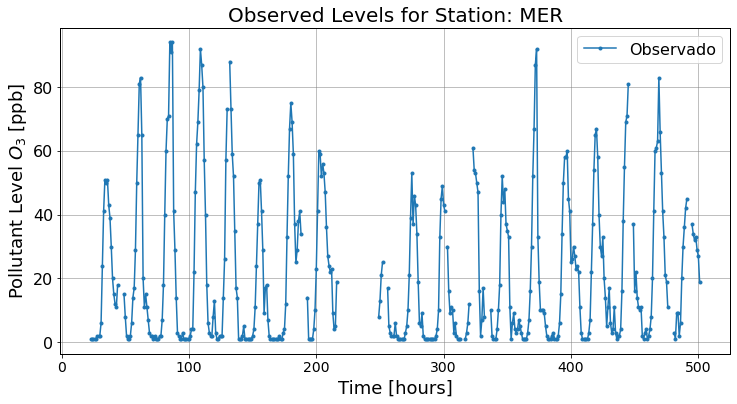

In [23]:
import matplotlib.pyplot as plt

def plot_simple(x_plot, y_true_column, title='Gráfica Simple', x_label='Eje X', y_label='Eje Y'):
    """
    Genera una gráfica simple de los datos proporcionados.

    Parámetros:
    x_data (iterable): Datos para el eje X.
    y_data (iterable): Datos para el eje Y.
    title (str): Título de la gráfica.
    x_label (str): Etiqueta para el eje X.
    y_label (str): Etiqueta para el eje Y.
    """
    plot_this_many = 24 * 20  # Number of points to plot

    plt.close('all')
    fig, ax = plt.subplots(figsize=[12, 6])

    ax.plot(x_plot[0:plot_this_many], y_true_column[0:plot_this_many], marker='.', label='Observado')

    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    ax.set_title(title, fontsize=20)

    # Configurar la cuadrícula
    ax.grid(True, color='grey', linestyle='-', linewidth=0.5)

    # Configurar los bordes (spines) de la gráfica
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.)

    ax.legend(fontsize=16)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)

    plt.show()

# Use example of observed Hours for introduction sections

y_true_column = y_true_df['plus_01_cont_otres_MER']
x_plot  = range(23, 23 + len(y_true_column))

# plot_simple(x_plot, y_true_column, title='Niveles Observados para la Estación: MER', x_label='Tiempo [horas]', y_label='Nivel de Contaminante $O_3$ [ppb]')
plot_simple(x_plot, y_true_column, title='Observed Levels for Station: MER', x_label='Time [hours]', y_label='Pollutant Level $O_3$ [ppb]')


In [24]:
#print(y_true_df)
#print(y_pred_descaled_df)

In [25]:
#y_true_df.to_csv('./)

## <a id="Some_Observed_Hours_Results">Some Observed Hours Results</a>
- [Return to Plots Index](#Plots_index)  

plus_01_cont_otres_UIZ


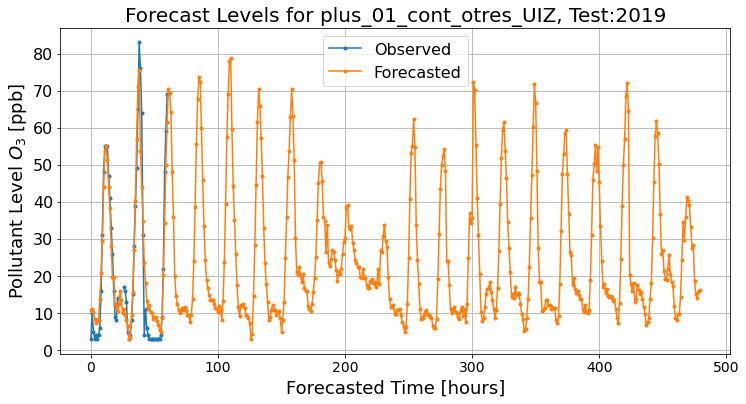

plus_06_cont_otres_UIZ


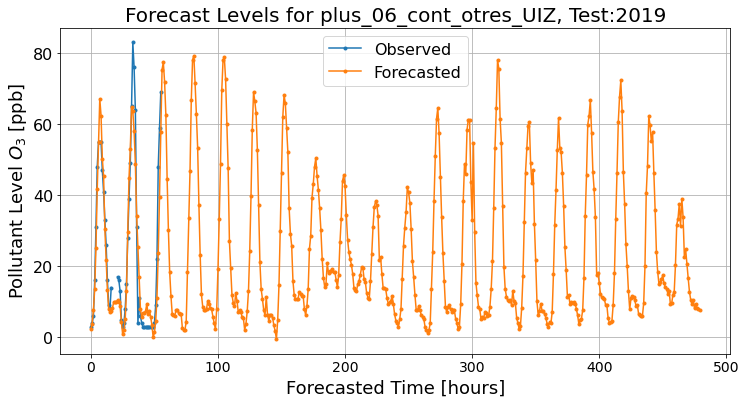

plus_12_cont_otres_UIZ


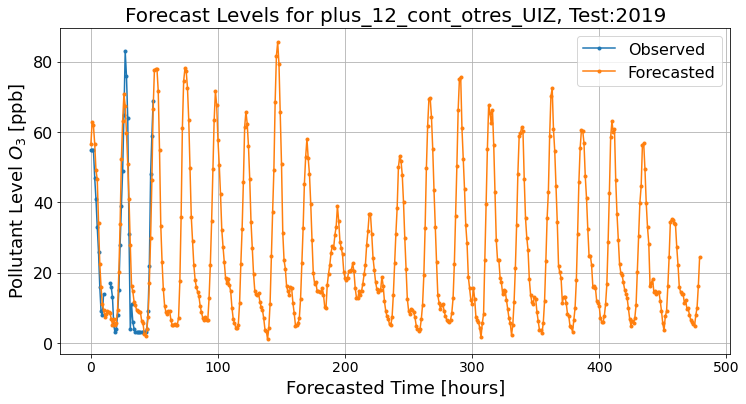

plus_18_cont_otres_UIZ


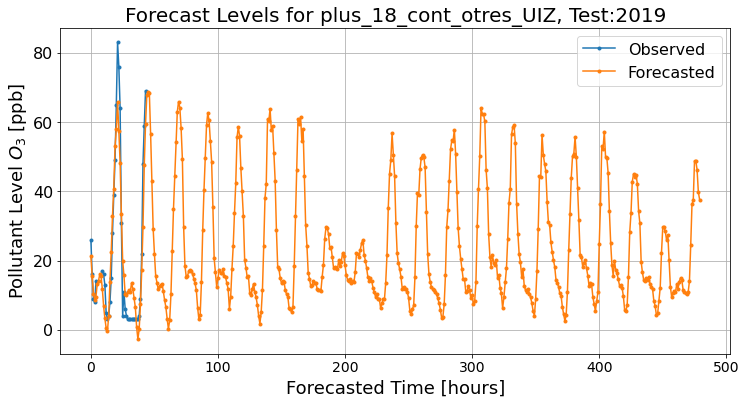

plus_24_cont_otres_UIZ


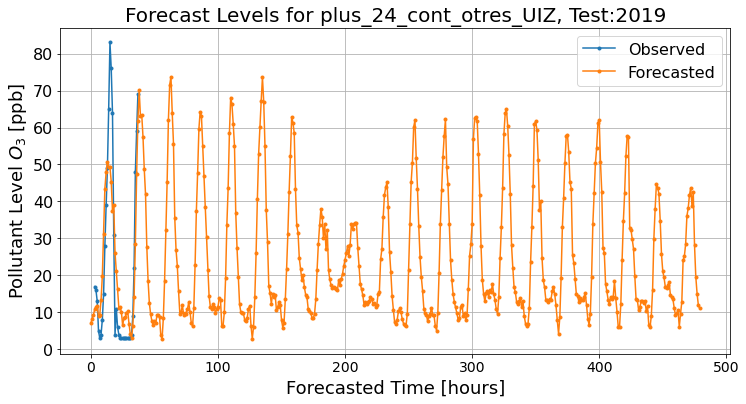

plus_01_cont_otres_AJU


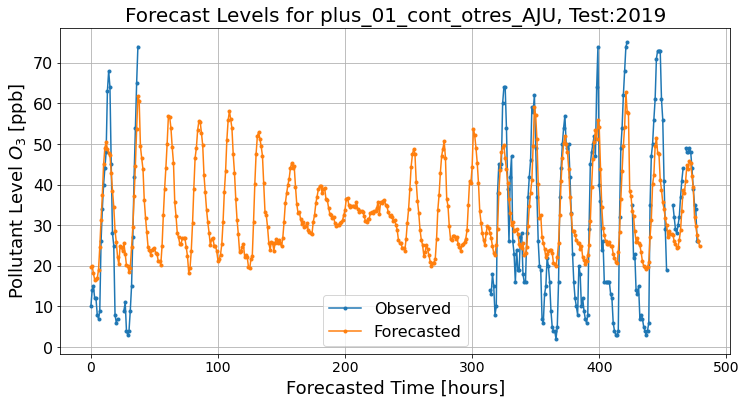

plus_06_cont_otres_AJU


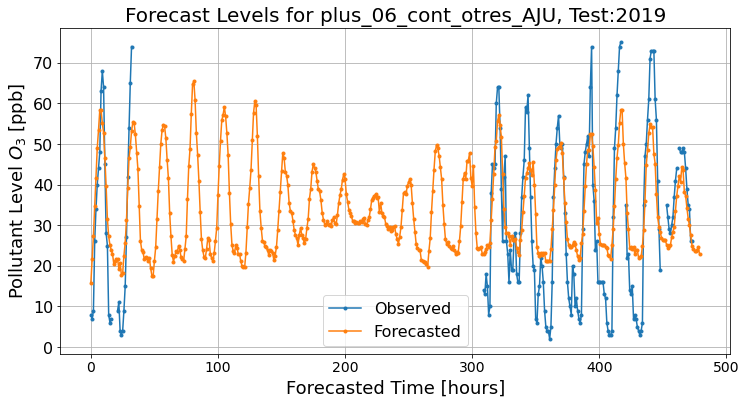

plus_12_cont_otres_AJU


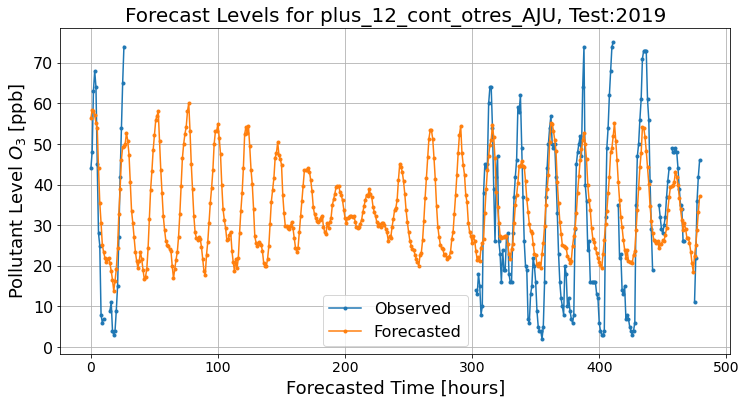

plus_18_cont_otres_AJU


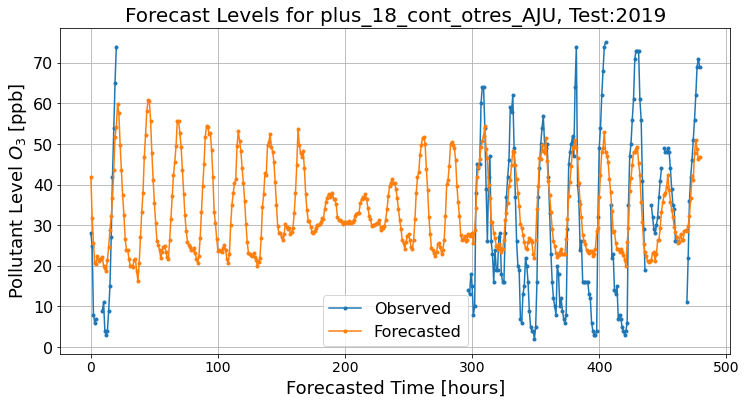

plus_24_cont_otres_AJU


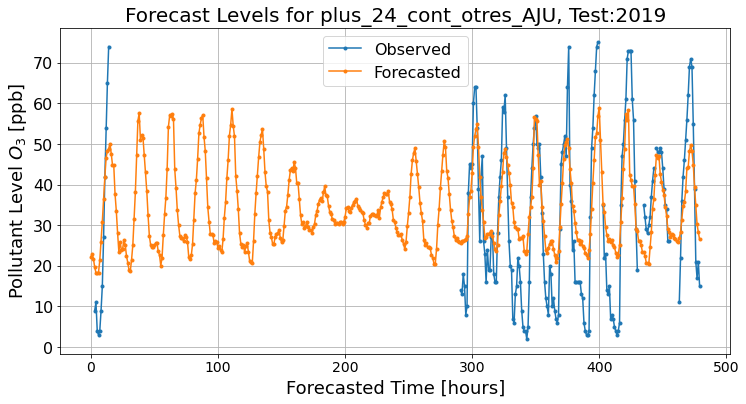

plus_01_cont_otres_ATI


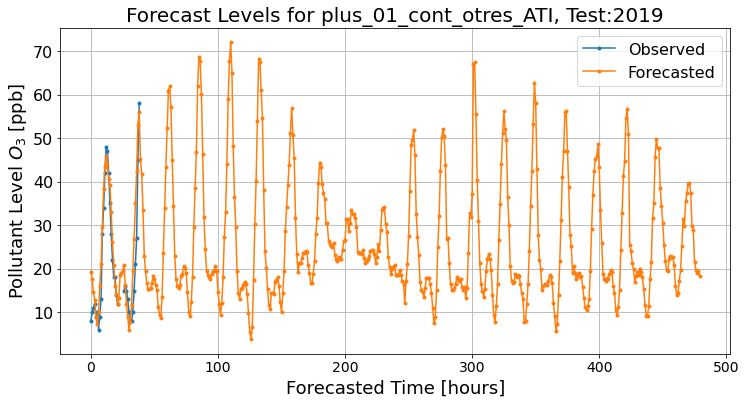

plus_06_cont_otres_ATI


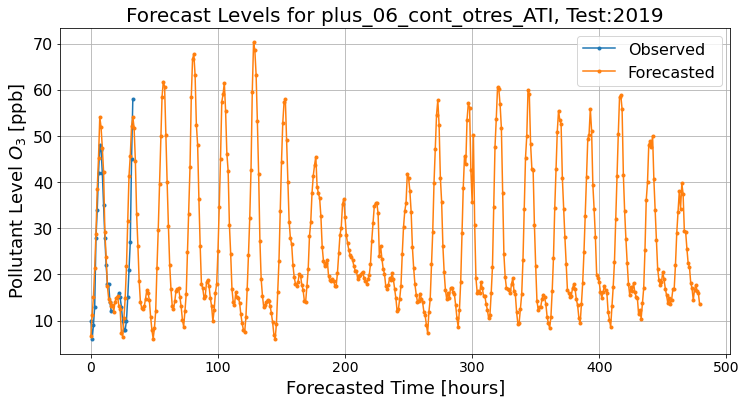

plus_12_cont_otres_ATI


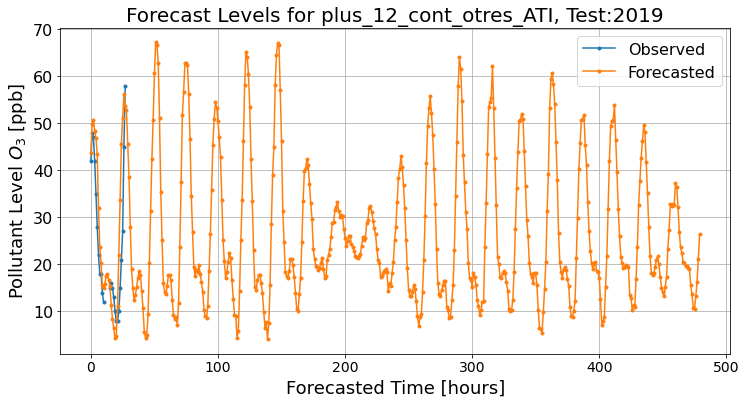

plus_18_cont_otres_ATI


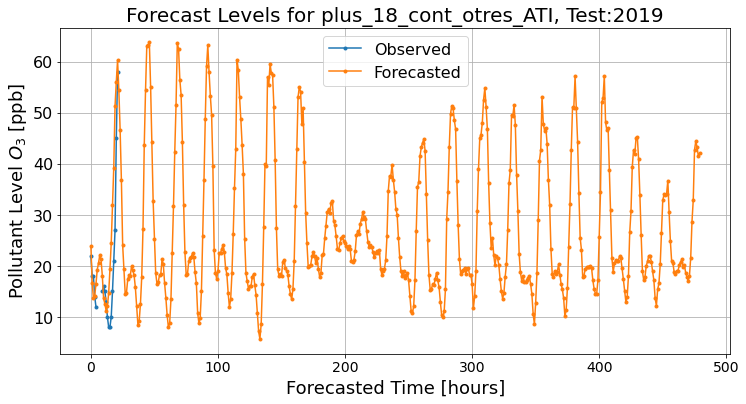

plus_24_cont_otres_ATI


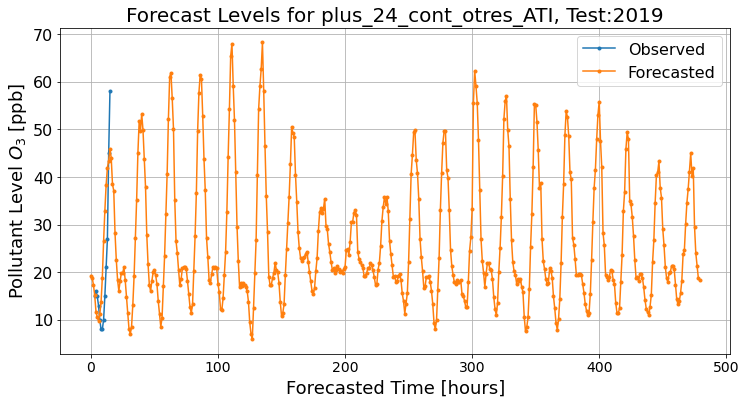

plus_01_cont_otres_UAX


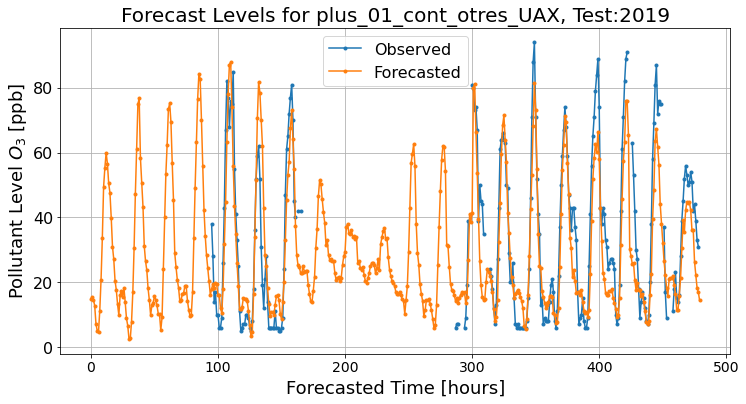

plus_06_cont_otres_UAX


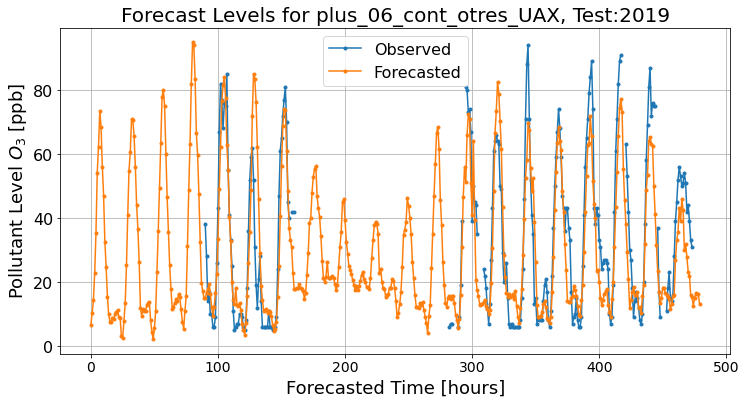

plus_12_cont_otres_UAX


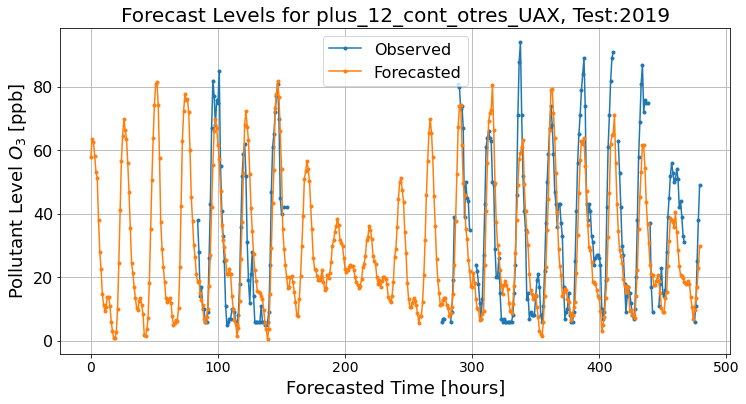

plus_18_cont_otres_UAX


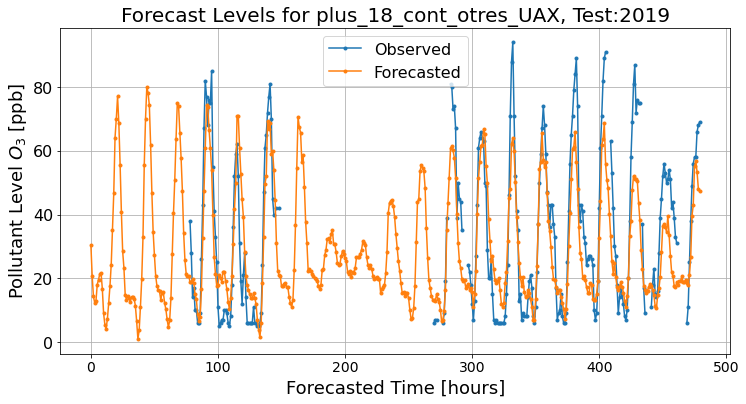

plus_24_cont_otres_UAX


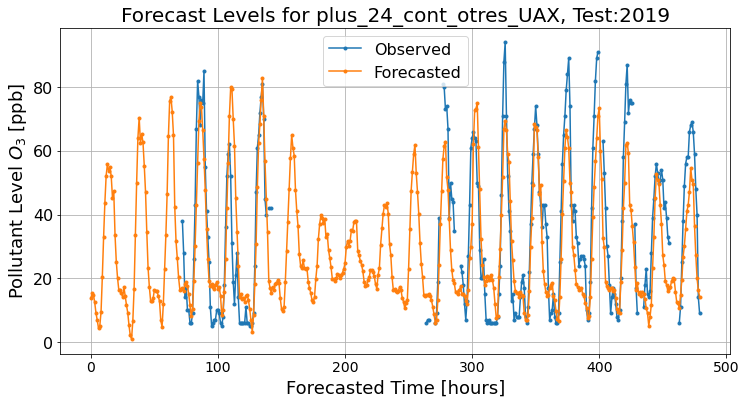

In [26]:
import matplotlib.pyplot as plt
from os.path import join

def plot_forecast_hours(column_to_plot, y_true_df, y_pred_descaled_df, 
                        output_results_folder_img=None, show_grid=True, 
                        x_label='Forecasted Time [hours]', y_label='Pollutant Level $O_3$ [ppb]', 
                        title_str=None, save_fig=True):
    """
    Generate a plot for forecast hours.

    Parameters:
    ...
    """
    plt.close('all')
    plot_this_many = 24 * 20  # Number of points to plot
    
    # Retrieve columns for plotting
    y_true_column = y_true_df[column_to_plot]
    y_pred_column = y_pred_descaled_df[column_to_plot]
    
    x_plot = range(len(y_true_column))
    
    # Plotting
    plt.figure(figsize=[12, 6])
    
    plt.xlabel(x_label, fontsize=18)
    plt.ylabel(y_label, fontsize=18)
    
    plt.plot(x_plot[0:plot_this_many], y_true_column[0:plot_this_many], marker='.', label='Observed')
    plt.plot(x_plot[0:plot_this_many], y_pred_column[0:plot_this_many], marker='.', label='Forecasted')
    
    if title_str is not None:
        plt.title(title_str, fontsize=20)
    else:
        plt.title(f'Forecast Levels for {column_to_plot}', fontsize=20)
        
    if show_grid:
        plt.grid(True)
    
    plt.legend(fontsize=16)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=16)
    
    if save_fig and output_results_folder_img:
        plt.savefig(join(output_results_folder_img, f'hours_plot_{column_to_plot.lower()}.png'), dpi=300)
    
    plt.show()

# Ploting forecast and observed hours on dataset

plt.close('all')

for cur_column in params_grid:
    print(cur_column)
    
    # Llamar a la función con la columna deseada y argumentos adicionales
    plot_forecast_hours(
        cur_column, 
        y_true_df, 
        y_pred_descaled_df, 
        output_results_folder_img=output_results_folder_img,
        show_grid=True, 
        x_label='Forecasted Time [hours]', 
        y_label='Pollutant Level $O_3$ [ppb]',
        title_str=f'Forecast Levels for {cur_column}, Test:2019',
        save_fig=True
    )


## <a id="Some_Hexbin">Some Hexbin Density Histograms</a>
- [Return to Plots Index](#Plots_index)  

column name:plus_01_cont_otres_UIZ
Correlation index:                     0.9392


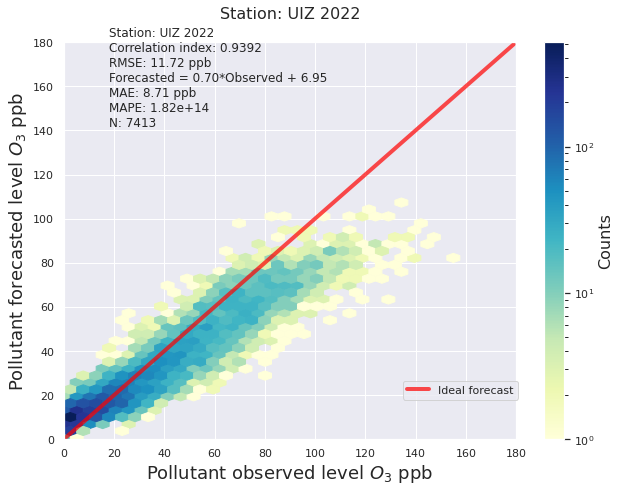

column name:plus_06_cont_otres_UIZ
Correlation index:                     0.9022


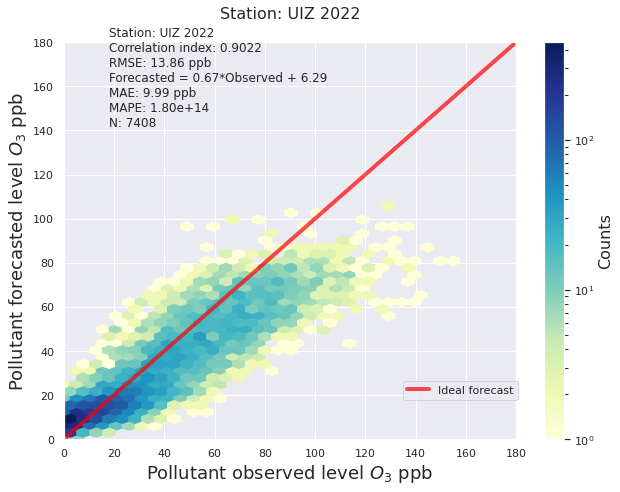

column name:plus_12_cont_otres_UIZ
Correlation index:                     0.9037


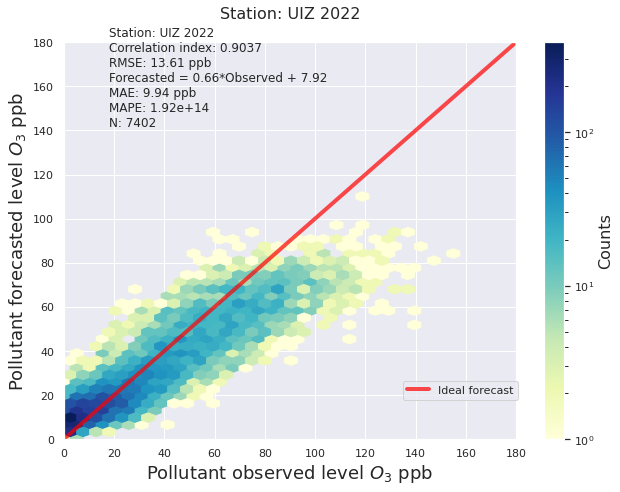

column name:plus_18_cont_otres_UIZ
Correlation index:                     0.9041


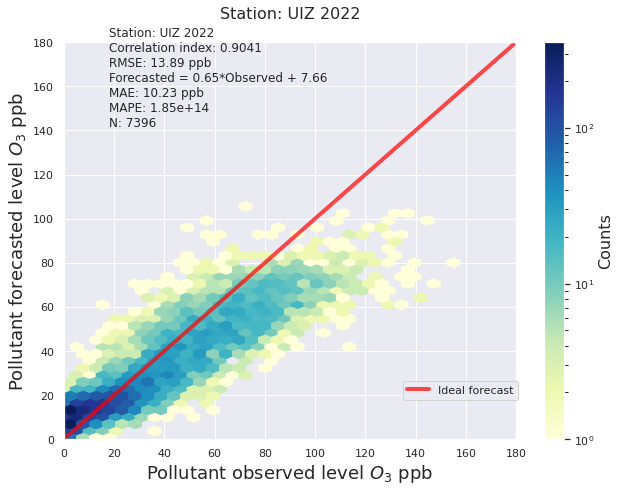

column name:plus_24_cont_otres_UIZ
Correlation index:                     0.8821


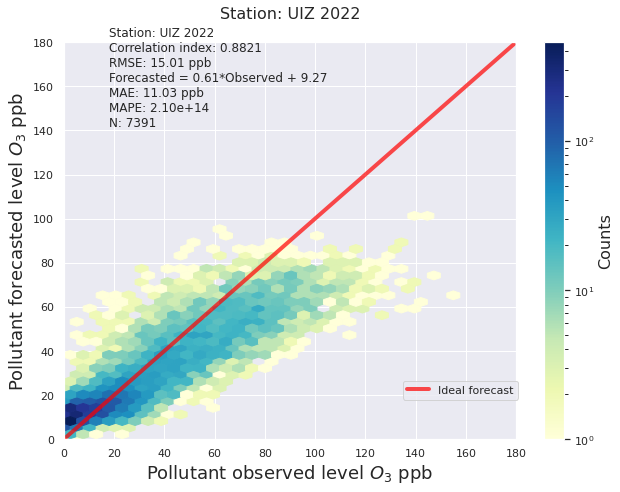

column name:plus_01_cont_otres_AJU
Correlation index:                     0.9104


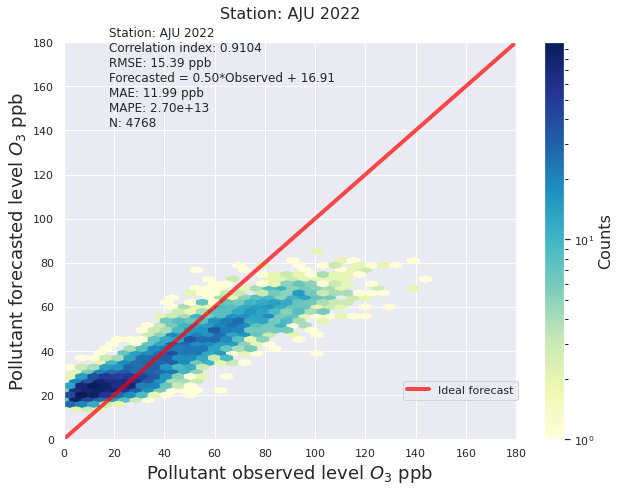

column name:plus_06_cont_otres_AJU
Correlation index:                     0.8827


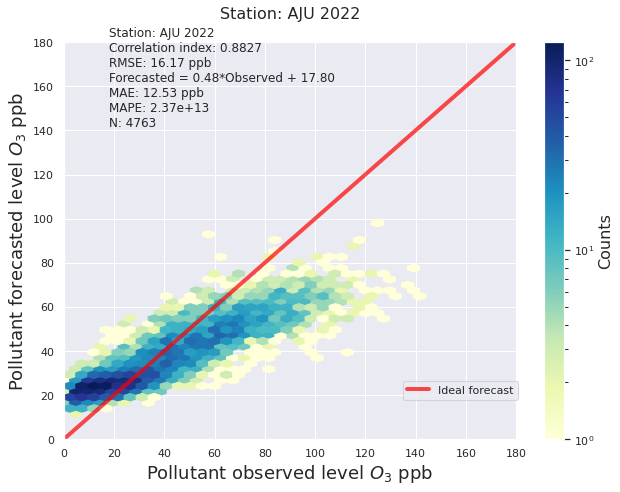

column name:plus_12_cont_otres_AJU
Correlation index:                     0.8794


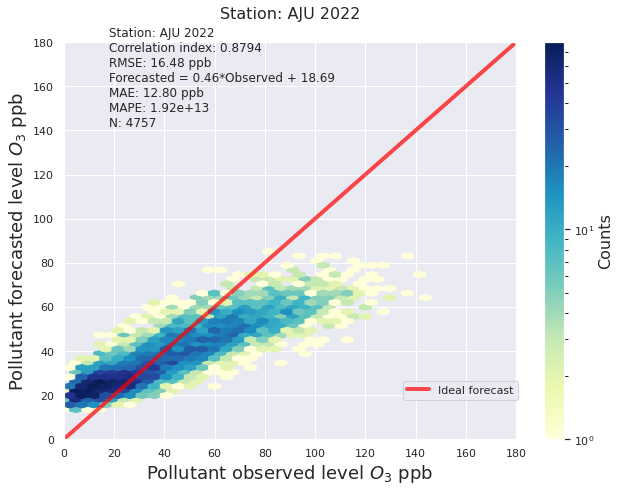

column name:plus_18_cont_otres_AJU
Correlation index:                     0.8878


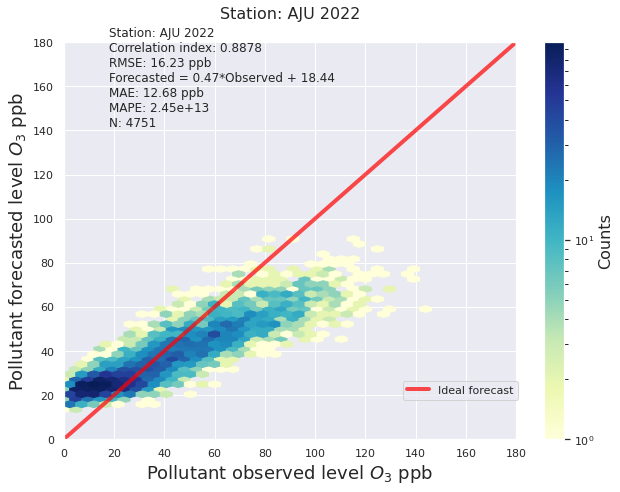

column name:plus_24_cont_otres_AJU
Correlation index:                     0.8707


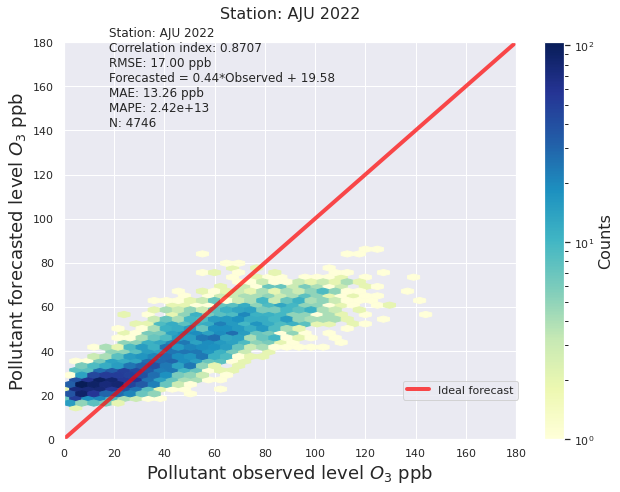

column name:plus_01_cont_otres_ATI
Correlation index:                     0.9226


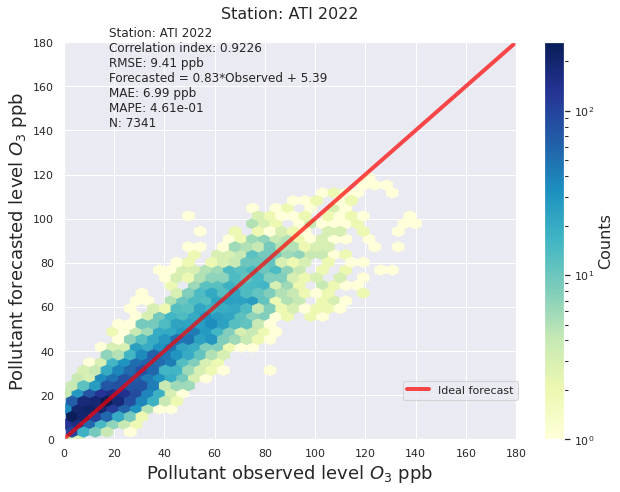

column name:plus_06_cont_otres_ATI
Correlation index:                     0.8939


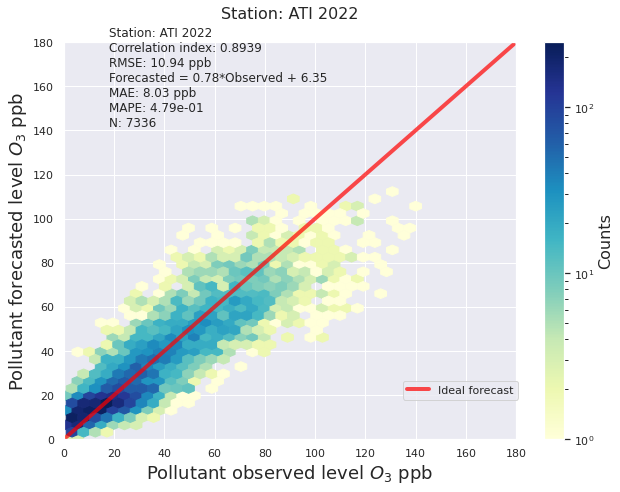

column name:plus_12_cont_otres_ATI
Correlation index:                     0.8805


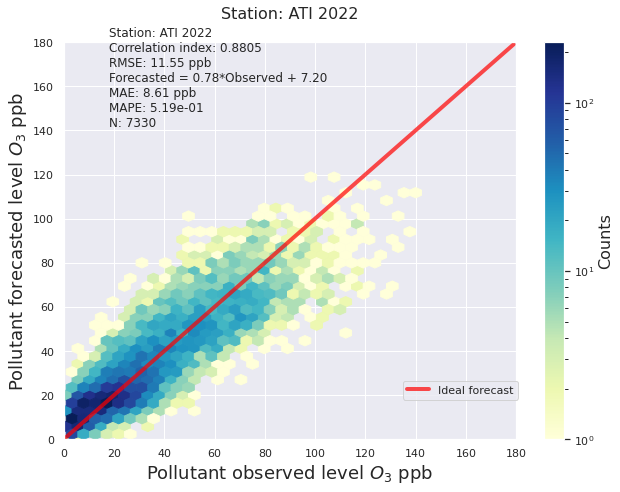

column name:plus_18_cont_otres_ATI
Correlation index:                     0.8828


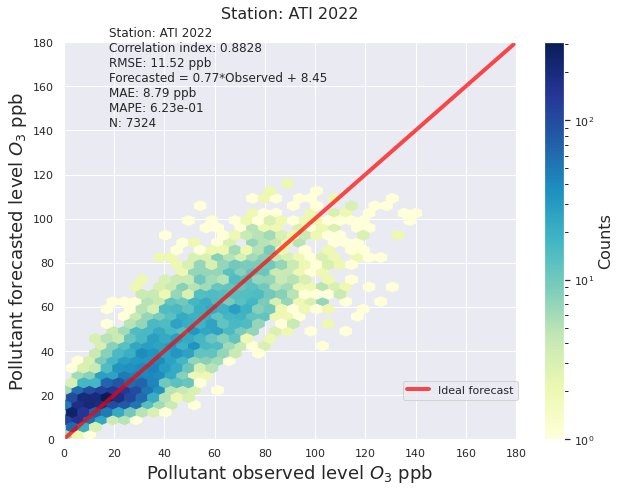

column name:plus_24_cont_otres_ATI
Correlation index:                     0.8767


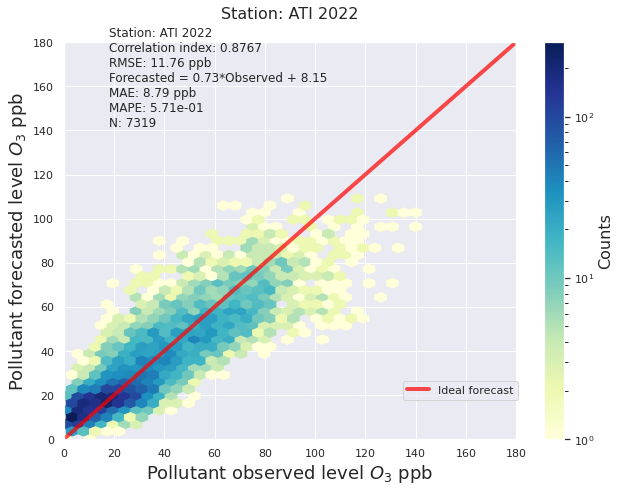

column name:plus_01_cont_otres_UAX
Correlation index:                     0.9384


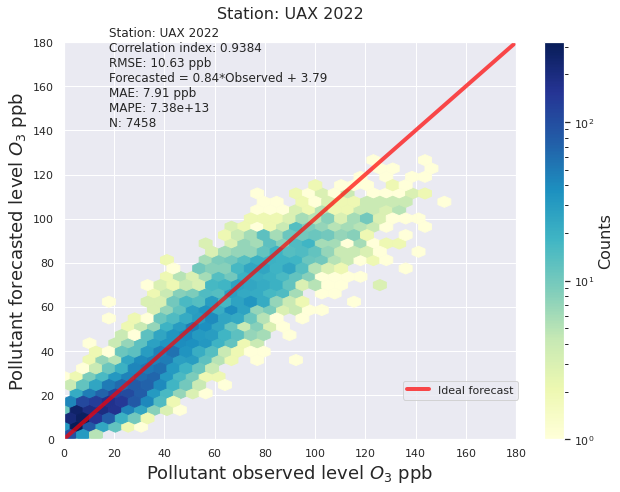

column name:plus_06_cont_otres_UAX
Correlation index:                     0.9092


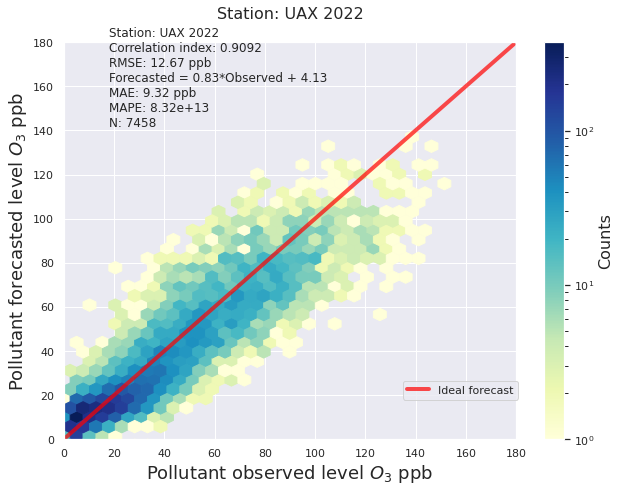

column name:plus_12_cont_otres_UAX
Correlation index:                     0.9039


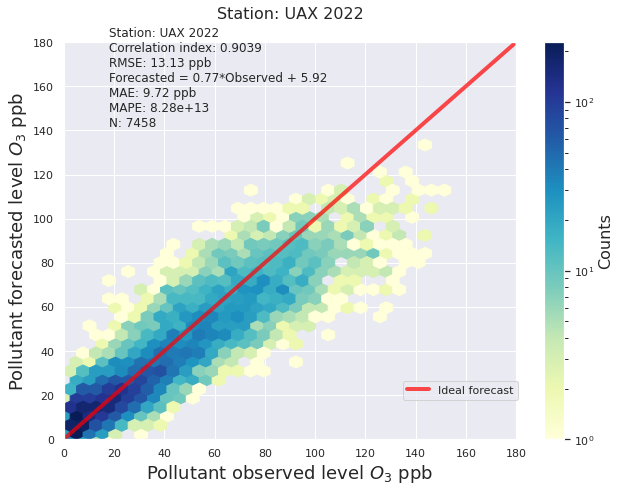

column name:plus_18_cont_otres_UAX
Correlation index:                     0.9016


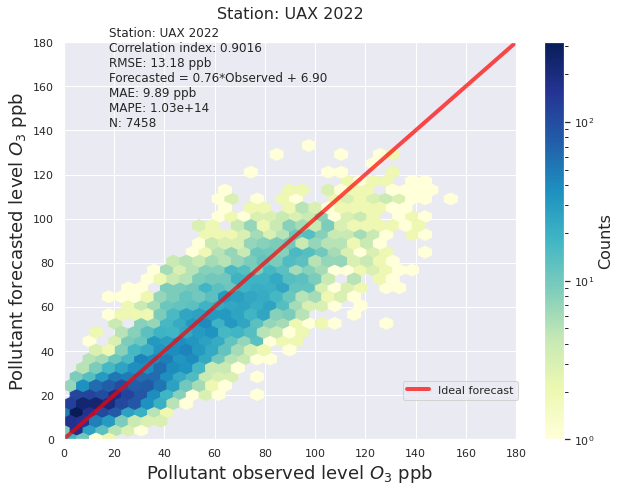

column name:plus_24_cont_otres_UAX
Correlation index:                     0.8925


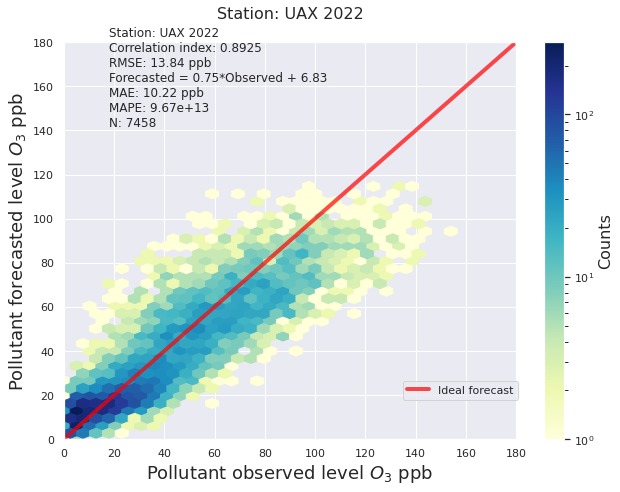

In [27]:
# %% Evaluating only a set of stations and hours
for station in evaluate_stations:
    for hour in evaluate_hours:
        cur_column = f'plus_{hour:02}_cont_otres_{station}'
        print(f'column name:{cur_column}')
        # analyze_column(cur_column)
        analyze_column(cur_column,
                       y_pred_descaled_df,
                       y_true_df,
                       test_year=test_year,
                       output_results_folder_img=output_results_folder_img)

# Visualize evolution of n_hours forecasted
#for station in evaluate_stations:
#    analyze_multi_hour_plot(
#        station,
#       evaluate_hours,
#        y_pred_descaled_df,
#        y_true_df,
#        test_year=test_year,
#       output_results_folder_img=output_results_folder_img)


In [28]:
# %% #Create DataFrame with metric results 

results_df = pd.DataFrame(columns=[
    "Columna", "Índice de correlación", "MAE", "MAPE", "MSE", "RMSE", "R2","Index of agreement"
])
for cur_column in y_pred_descaled_df.columns:
    #print(cur_column)
    try:
        column_results = analyze_column(cur_column,
                                        y_pred_descaled_df,
                                        y_true_df,
                                        test_year=test_year,
                                        generate_plot=False)
    except:
        column_results = []
    results_df = results_df.append(column_results, ignore_index=True)


Correlation index:                     0.9392
Correlation index:                     0.9104
Correlation index:                     0.9226
Correlation index:                     0.8875
Correlation index:                     0.9233
Correlation index:                     0.9194
Correlation index:                     0.9146
Correlation index:                     0.9356
Correlation index:                     0.9138
Correlation index:                     0.9255
Correlation index:                     0.9422
Correlation index:                     0.9356
Correlation index:                     0.9546
Correlation index:                     0.9049
Correlation index:                     0.9411
Correlation index:                     0.9230
Correlation index:                     0.9313
Correlation index:                     0.9207
Correlation index:                     0.9417
Correlation index:                     nan
Correlation index:                     0.9319
Correlation index:                   

Correlation index:                     0.8496
Correlation index:                     0.8829
Correlation index:                     0.8982
Correlation index:                     0.8781
Correlation index:                     0.8929
Correlation index:                     0.8199
Correlation index:                     0.8704
Correlation index:                     0.8819
Correlation index:                     0.8981
Correlation index:                     0.8770
Correlation index:                     0.8752
Correlation index:                     0.8909
Correlation index:                     0.8943
Correlation index:                     0.8874
Correlation index:                     0.8902
Correlation index:                     0.8708
Correlation index:                     0.8951
Correlation index:                     0.8645
Correlation index:                     0.8732
Correlation index:                     0.8715
Correlation index:                     0.8995
Correlation index:                

Correlation index:                     0.8702
Correlation index:                     0.9032
Correlation index:                     0.8837
Correlation index:                     0.8825
Correlation index:                     0.8264
Correlation index:                     0.8676
Correlation index:                     0.8826
Correlation index:                     0.8855
Correlation index:                     0.8863
Correlation index:                     0.8783
Correlation index:                     0.8791
Correlation index:                     0.8964
Correlation index:                     0.8862
Correlation index:                     0.9092
Correlation index:                     0.8528
Correlation index:                     0.8905
Correlation index:                     0.8619
Correlation index:                     0.8736
Correlation index:                     0.8691
Correlation index:                     0.9006
Correlation index:                     nan
Correlation index:                   

Correlation index:                     0.8720
Correlation index:                     0.8886
Correlation index:                     0.8752
Correlation index:                     0.8770
Correlation index:                     0.8886
Correlation index:                     0.8873
Correlation index:                     0.8855
Correlation index:                     0.8803
Correlation index:                     0.8496
Correlation index:                     0.8903
Correlation index:                     0.8533
Correlation index:                     0.8663
Correlation index:                     0.8662
Correlation index:                     0.8873
Correlation index:                     nan
Correlation index:                     0.8860
Correlation index:                     0.8938
Correlation index:                     0.8990
Correlation index:                     0.8951
Correlation index:                     0.8250
Correlation index:                     0.8853
Correlation index:                   


for cur_column in y_pred_descaled_df.columns:
    #print(cur_column)
    try:
        column_results = analyze_column(cur_column,
                                        y_pred_descaled_df,
                                        y_true_df,
                                        test_year=test_year,
                                        generate_plot=False)
    except:
        column_results = [cur_column, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
    results_df = results_df.append(column_results, ignore_index=True)




In [29]:
# Extract unique station identifiers from the "Columna" column
station_identifiers = results_df['Columna'].str.split('_').str[4].unique()
station_identifiers

array(['UIZ', 'AJU', 'ATI', 'CUA', 'SFE', 'SAG', 'CUT', 'PED', 'TAH',
       'GAM', 'IZT', 'CCA', 'HGM', 'LPR', 'MGH', 'CAM', 'FAC', 'TLA',
       'MER', 'LLA', 'TLI', 'UAX', 'BJU', 'MPA', 'MON', 'NEZ', 'INN',
       'AJM', 'VIF'], dtype=object)

In [30]:
results_df.rename(columns={'Índice de correlación': 'Correlation Index'}, inplace=True)


In [31]:
results_df

Columna  Correlation Index        MAE          MAPE  \
0    plus_01_cont_otres_UIZ           0.939165   8.709189  1.821618e+14   
1    plus_01_cont_otres_AJU           0.910427  11.992657  2.698329e+13   
2    plus_01_cont_otres_ATI           0.922638   6.993101  4.606342e-01   
3    plus_01_cont_otres_CUA           0.887523   9.320794  1.734617e+14   
4    plus_01_cont_otres_SFE           0.923270   9.452324  4.477150e-01   
..                      ...                ...        ...           ...   
691  plus_24_cont_otres_MON           0.880904  10.972673  5.788248e+12   
692  plus_24_cont_otres_NEZ           0.885270  10.556931  2.729143e+13   
693  plus_24_cont_otres_INN           0.731702  12.782560  7.250953e-01   
694  plus_24_cont_otres_AJM           0.835438  11.954727  4.713851e-01   
695  plus_24_cont_otres_VIF           0.871343  10.208917  6.454470e+13   

            MSE       RMSE        R2  Index of agreement  
0    137.412276  11.722298  0.834595            0.944245  
1    236.971964  15.393894  0.682600            0.862956  
2     88.641404   9.414956  0.850502            0.956915  
3    151.604356  12.312772  0.759845            0.924540  
4    157.136490  12.535409  0.810109            0.938235  
..          ...        ...       ...                 ...  
691  189.496964  13.765790  0.723833            0.895324  
692  196.799374  14.028520  0.741350            0.909305  
693  218.392108  14.778096  0.006794            0.715835  
694  245.750755  15.676439  0.665083            0.869975  
695  183.131680  13.532615  0.705548            0.887167  

[696 rows x 8 columns]

## <a id="Scatter_Metrics_for_Model_Outputs">Scatter Metrics for Model Outputs</a>
### MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Plots index return](#Plots_index)

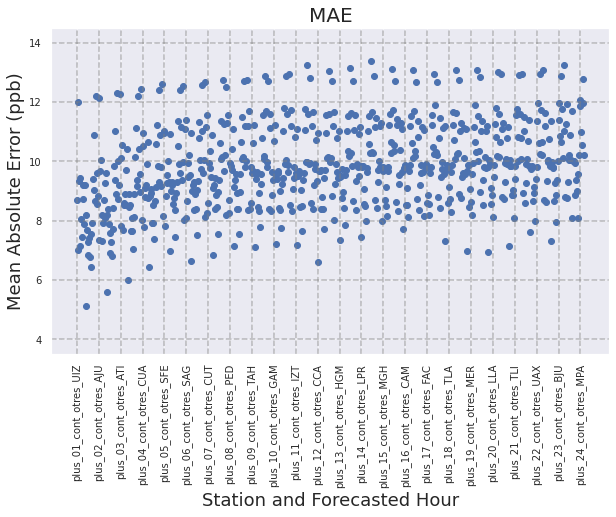

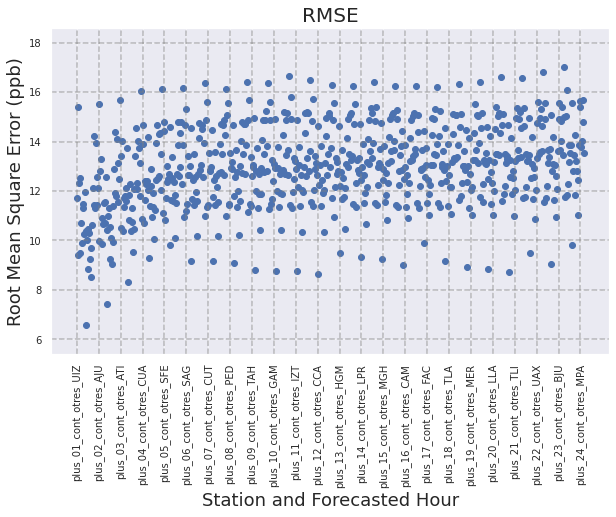

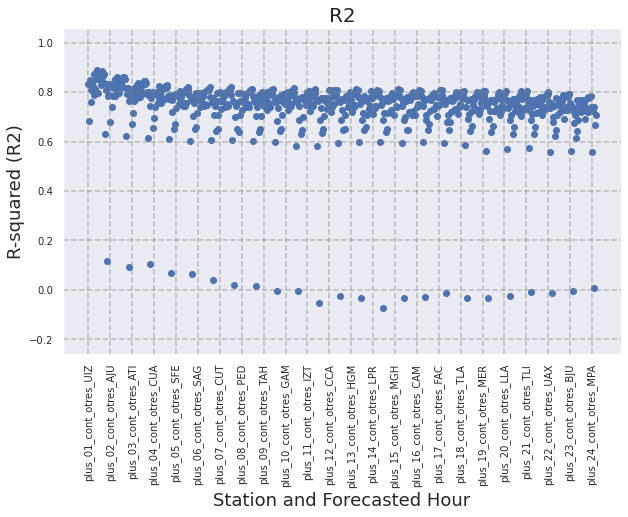

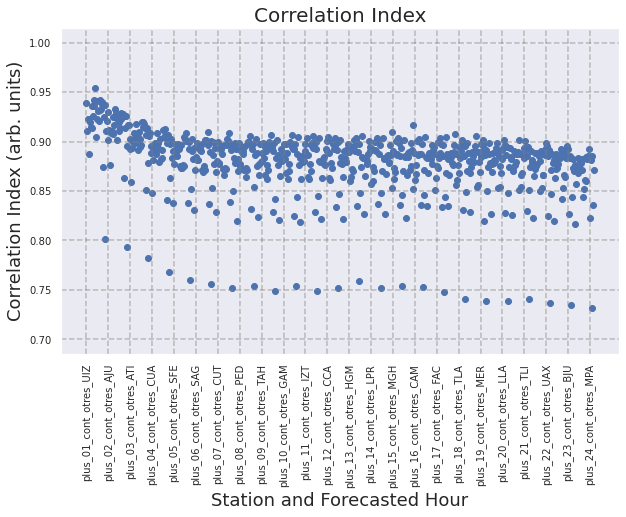

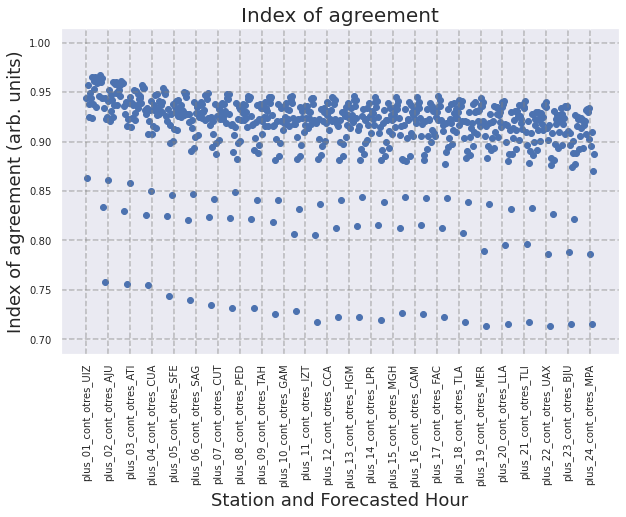

In [32]:
from os.path import join
import matplotlib.pyplot as plt

def scatter_plot_by_column(df, metric, output_folder=None, 
                           show_grid=True, x_label='Station and forecasted hours', 
                           y_label=None, title_str=True, save_fig=True,
                           x_label_fontsize=18, y_label_fontsize=18, 
                           title_fontsize=20, tick_fontsize=14):
    
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[metric])
    
    plt.xlabel(x_label, fontsize=x_label_fontsize)
    plt.ylabel(y_label if y_label else metric, fontsize=y_label_fontsize)
    
    if title_str:
        title_str = f'{metric}'
    else:
        title_str = ''
        
    plt.title(title_str, fontsize=title_fontsize)
    
    x_ticks = df.index[::30]
    x_labels = df['Columna'][::30]
    plt.xticks(x_ticks, x_labels, rotation=90, fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    
    if show_grid:
        for x in x_ticks:
            plt.axvline(x, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='x', linestyle='dashed', alpha=0.5)
        
        y_ticks = plt.gca().get_yticks()
        for y in y_ticks:
            plt.axhline(y, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)
    
    if save_fig and output_folder:
        plt.savefig(join(output_folder, f'scatter_plot_{metric.lower()}.png'), dpi=300)
        
    plt.show()
# Para MAE
scatter_plot_by_column(results_df, 'MAE',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Station and Forecasted Hour', 
                y_label='Mean Absolute Error (ppb)', 
                title_str='Mean Absolute Error Across Stations and Forecasted Hours', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)

# Para RMSE
scatter_plot_by_column(results_df, 'RMSE',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Station and Forecasted Hour', 
                y_label='Root Mean Square Error (ppb)', 
                title_str='Root Mean Square Error Across Stations and Forecasted Hours', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)

# Para R2
scatter_plot_by_column(results_df, 'R2',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Station and Forecasted Hour', 
                y_label='R-squared (R2)', 
                title_str='R-squared (R2) Across Stations and Forecasted Hours', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)
# CC
scatter_plot_by_column(results_df, 'Correlation Index',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Station and Forecasted Hour', 
                y_label='Correlation Index (arb. units)', 
                title_str='Correlation Index Across Stations and Forecasted Hours', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)


# IoA
scatter_plot_by_column(results_df, 'Index of agreement',
                output_results_folder_img, 
                show_grid=True, 
                x_label='Station and Forecasted Hour', 
                y_label='Index of agreement (arb. units)', 
                title_str='Index of agreement Across Stations and Forecasted Hours', 
                save_fig=True,
                x_label_fontsize=18, 
                y_label_fontsize=18, 
                title_fontsize=20, 
                tick_fontsize=10)

## <a id="Bar_Charts_Averaging_Metrics_over_Stations">Bar Charts Averaging Metrics over Stations</a>
### MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Return to Plots Index](#Plots_index) 

Per station MAE: 9.8220


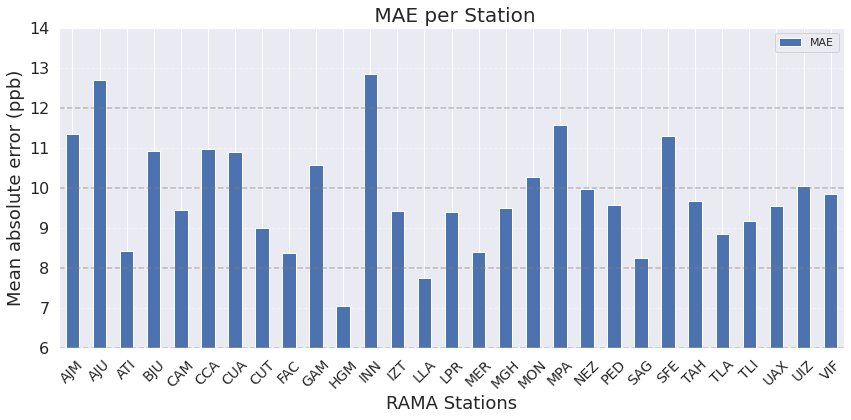

Per station RMSE: 12.9354


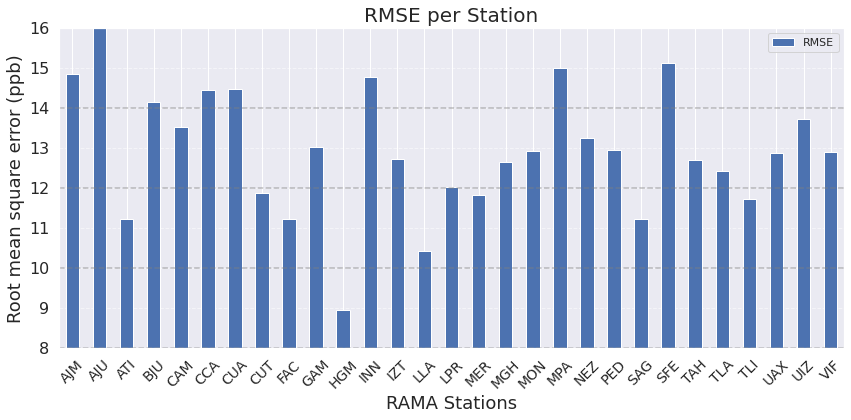

Per station R2: 0.7293


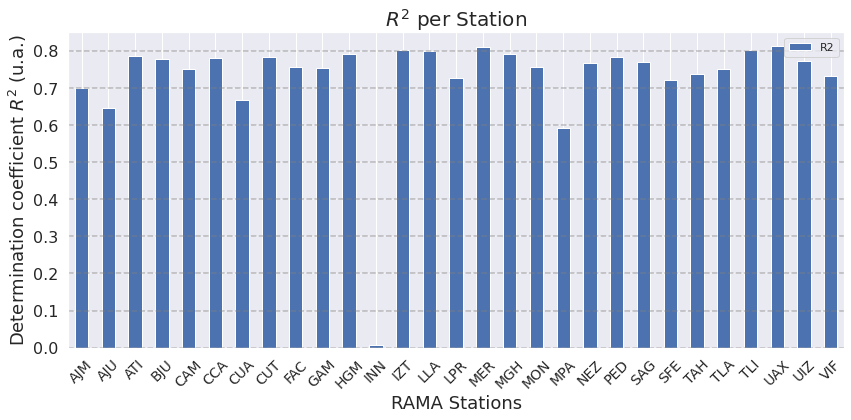

Per station Correlation Index: 0.8796


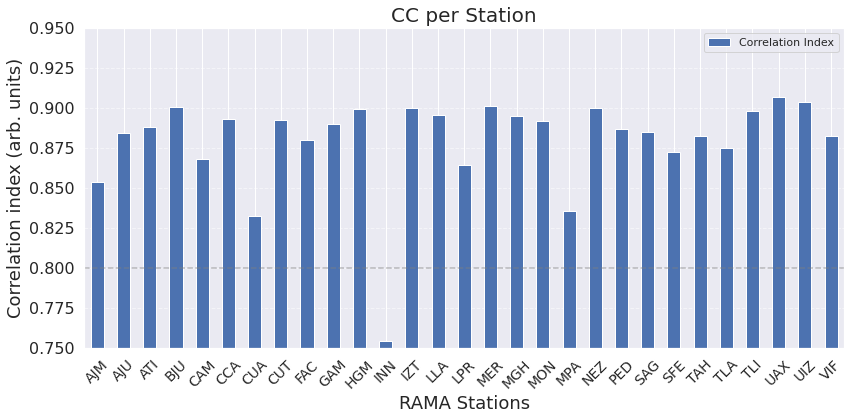

Per station Index of agreement: 0.9102


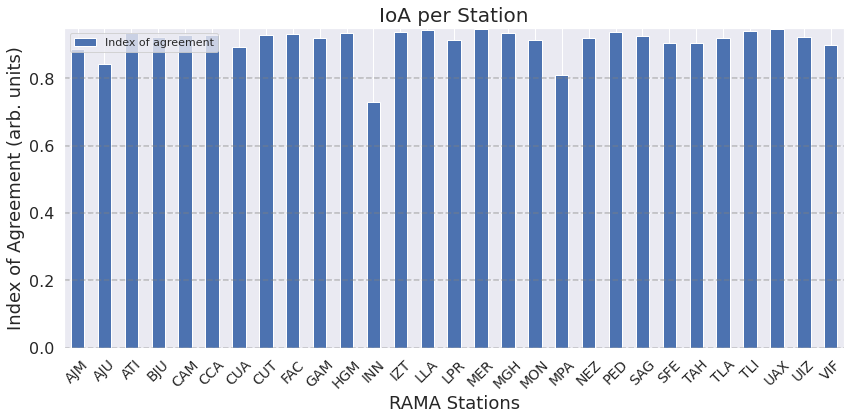

In [33]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

def average_metric(results_df, metric, output_results_folder_img=None, 
                    show_grid=True, x_label='Station', y_label=None, 
                    title_suffix='', save_fig=True, title_str=True,
                    subtitle=True, y_limit=None):  # Agregar el nuevo parámetro aquí
    """
    Generate a bar plot for average metrics.
    
    Parameters:
    ...
    y_limit: tuple, optional
        A tuple (min, max) to set the y-axis limits.
    """
# def average_metric(results_df, metric, output_results_folder_img=None, 
#                     show_grid=True, x_label='Station', y_label=None, 
#                     title_suffix='', save_fig=True, title_str=True,
#                     subtitle=True):
#     """
#     Generate a bar plot for average metrics.
    
#     Parameters:
#     ...
#     """

    # Helper function to calculate average metrics
    def calculate_average_metrics(df, key):
        return df[df['Columna'].str.endswith(key)][metric].mean()

    station_keys = sorted(set(results_df['Columna'].apply(lambda x: x.split('_')[-1])))
    average_metrics = [calculate_average_metrics(results_df, key) for key in station_keys]
    
    # Create DataFrame
    average_metrics_df = pd.DataFrame({x_label: station_keys, metric: average_metrics})

    # Overall Average
    overall_average_metric = average_metrics_df[metric].mean()
    print(f"Per station {metric}: {overall_average_metric:.4f}")

    # Plotting
    ax = average_metrics_df.plot(x=x_label, y=metric, kind='bar', figsize=(12, 6))

    # Title Handling
    if isinstance(title_str, str):
        pass
    elif title_str:
        title_str = f'{title_suffix}'
    else:
        title_str = ''
    
    if subtitle:
        title_str += f"\n Overall stations {metric} {overall_average_metric:.4f}"
    
    ax.set_title(title_str, fontsize=20)
    ax.set_ylabel(y_label if y_label else metric, fontsize=18)
    ax.set_xlabel(x_label, fontsize=18)
    
    if show_grid:
        y_ticks = plt.gca().get_yticks()  # Obtener los ticks del eje y
        for y in y_ticks:
            plt.axhline(y, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)  # Agregar grid en el eje y
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)

    if y_limit:  # Aplicar los límites del eje Y si se proporcionan
        ax.set_ylim(y_limit)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_fig and output_results_folder_img:
        plt.savefig(join(output_results_folder_img, f'avg_metric_plot_{metric.lower()}.png'), dpi=300)
    
    plt.show()
    
average_metric(results_df, 'MAE', output_results_folder_img, show_grid=True, 
               x_label='RAMA Stations', y_label='Mean absolute error (ppb)', 
               title_str=True, title_suffix=' MAE per Station', save_fig=True, 
               subtitle=False, y_limit=(6, 14))

# RMSE con límites entre 10 y 16
average_metric(results_df, 'RMSE', output_results_folder_img, show_grid=True, 
               x_label='RAMA Stations', y_label='Root mean square error (ppb)', 
               title_str=True, title_suffix='RMSE per Station', save_fig=True, 
               subtitle=False, y_limit=(8, 16))

# R2 
average_metric(results_df, 'R2', output_results_folder_img, show_grid=True, 
               x_label='RAMA Stations', y_label='Determination coefficient $R^2$ (u.a.)', 
               title_str=True, title_suffix='$R^2$ per Station', save_fig=True, 
               subtitle=False, y_limit=(0, 0.85))

# Correlation Index 
average_metric(results_df, 'Correlation Index', output_results_folder_img, show_grid=True, 
               x_label='RAMA Stations', y_label='Correlation index (arb. units)', 
               title_str=True, title_suffix='CC per Station', save_fig=True, 
               subtitle=False, y_limit=(0.75, 0.95))

# Index of Agreement con límites entre 0.8 y 0.95
average_metric(results_df, 'Index of agreement', output_results_folder_img, show_grid=True, 
               x_label='RAMA Stations', y_label='Index of Agreement (arb. units)', 
               title_str=True, title_suffix='IoA per Station', save_fig=True, 
               subtitle=False, y_limit=(0, 0.95))



import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

def average_metric(results_df, metric, output_results_folder_img=None, 
                    show_grid=True, x_label='Station', y_label=None, 
                    title_suffix='', save_fig=True, title_str=True,
                    subtitle=True):
    """
    Generate a bar plot for average metrics.
    
    Parameters:
    ...
    """

    # Helper function to calculate average metrics
    def calculate_average_metrics(df, key):
        return df[df['Columna'].str.endswith(key)][metric].mean()

    station_keys = sorted(set(results_df['Columna'].apply(lambda x: x.split('_')[-1])))
    average_metrics = [calculate_average_metrics(results_df, key) for key in station_keys]
    
    # Create DataFrame
    average_metrics_df = pd.DataFrame({x_label: station_keys, metric: average_metrics})

    # Overall Average
    overall_average_metric = average_metrics_df[metric].mean()
    print(f"Per station {metric}: {overall_average_metric:.4f}")

    # Plotting
    ax = average_metrics_df.plot(x=x_label, y=metric, kind='bar', figsize=(12, 6))

    # Title Handling
    if isinstance(title_str, str):
        pass
    elif title_str:
        title_str = f'Per station {metric} {title_suffix}'
    else:
        title_str = ''
    
    if subtitle:
        title_str += f"\n Overall stations {metric} {overall_average_metric:.4f}"
    
    ax.set_title(title_str, fontsize=20)
    ax.set_ylabel(y_label if y_label else metric, fontsize=18)
    ax.set_xlabel(x_label, fontsize=18)
    
    if show_grid:
        y_ticks = plt.gca().get_yticks()  # Obtener los ticks del eje y
        for y in y_ticks:
            plt.axhline(y, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)  # Agregar grid en el eje y
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_fig and output_results_folder_img:
        plt.savefig(join(output_results_folder_img, f'avg_metric_plot_{metric.lower()}.png'), dpi=300)
    
    plt.show()


average_metric(results_df, 'MAE', output_results_folder_img, show_grid=True, x_label='RAMA Stations', y_label='Mean absolute error (ppb)',title_str=True,title_suffix='(ppb)', save_fig=True,subtitle=False)
average_metric(results_df, 'RMSE', output_results_folder_img, show_grid=True, x_label='RAMA Stations', y_label='Root mean square error (ppb)',title_str=True,title_suffix='(ppb)', save_fig=True,subtitle=False)
average_metric(results_df, 'R2', output_results_folder_img, show_grid=True, x_label='RAMA Stations', y_label='R2 (arb. units)',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric(results_df, 'Correlation Index', output_results_folder_img, show_grid=True, x_label='RAMA Stations', y_label='Correlation index (arb. units)',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric(results_df, 'Index of agreement', output_results_folder_img, show_grid=True, x_label='RAMA Stations', y_label='Index of Agreement (arb. units)',title_str=True,title_suffix='', save_fig=True,subtitle=False)


## <a id="Bar_Charts_Averaging_Metrics_over_Hours">Bar Charts Averaging Metrics over Hours</a>
### MAE, RMSE, R2, Correlation Index, Index of Agreement
- [Return to Plots Index](#Plots_index)  

Overall average of MAE across all hours: 9.8220


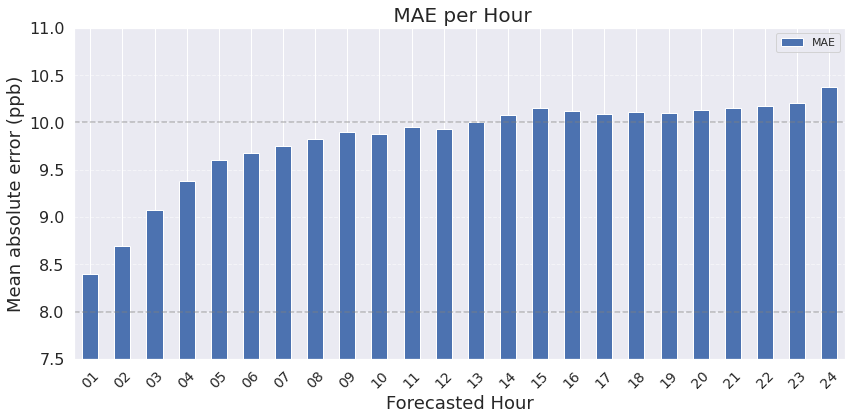

Overall average of RMSE across all hours: 12.9354


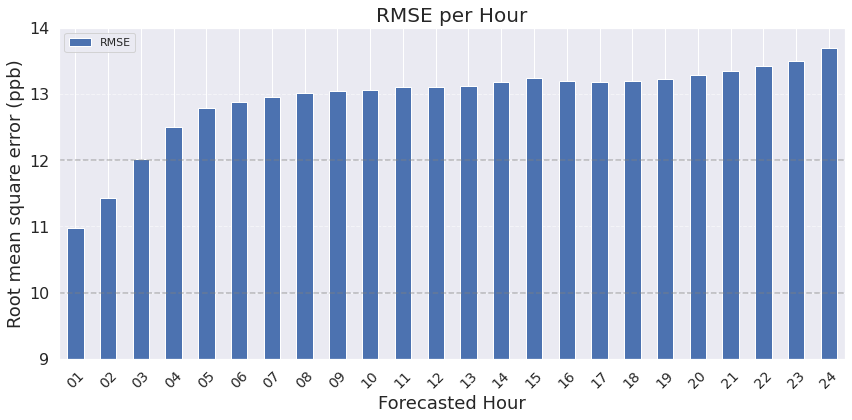

Overall average of R2 across all hours: 0.7293


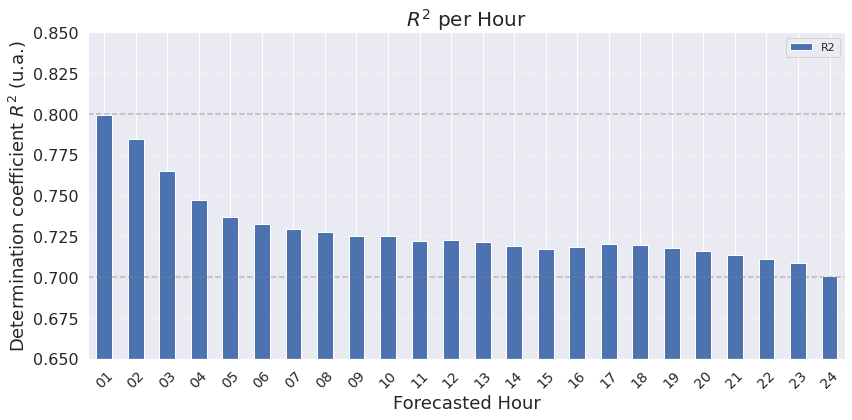

Overall average of Correlation Index across all hours: 0.8796


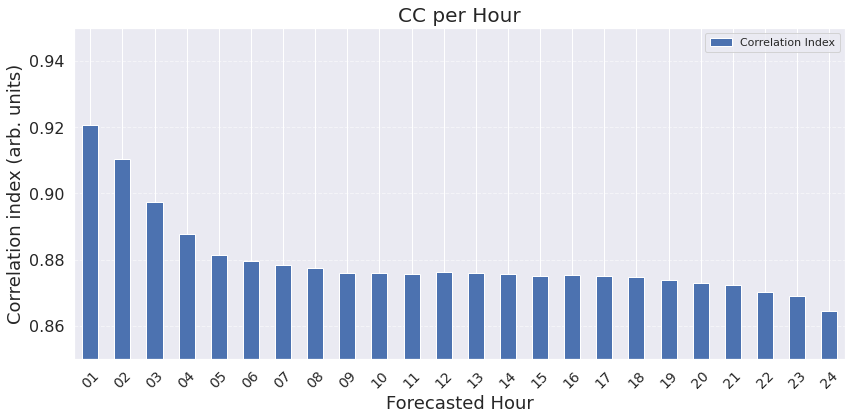

Overall average of Index of agreement across all hours: 0.9102


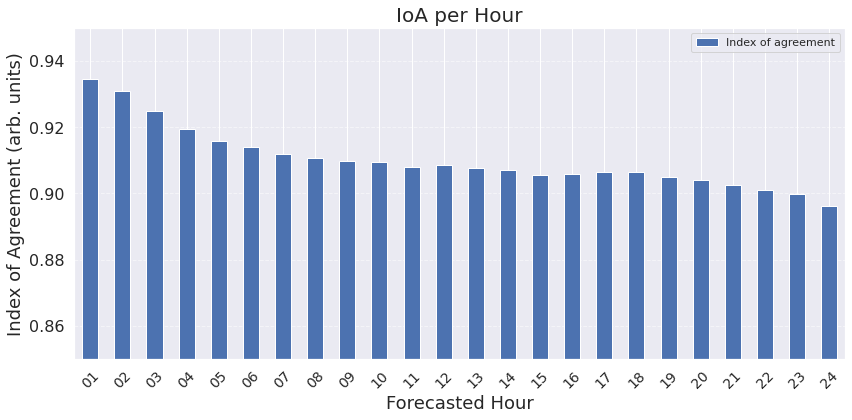

In [34]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

def average_metric_by_hour(results_df, metric, output_results_folder_img=None, 
                           show_grid=True, x_label='Forecasted Hour', y_label=None, 
                           title_suffix='', save_fig=True, title_str=True, 
                           subtitle=True, y_limit=None):
    """
    Generate a bar plot for average metrics by hour.
    
    Parameters:
    ...
    """

    # Helper function to calculate average metrics by hour
    def calculate_average_metrics_by_hour(df, key):
        return df[df['Columna'].str.contains(key)][metric].mean()

    hour_keys = sorted(set(results_df['Columna'].apply(lambda x: x.split('_')[1])), 
                       key=lambda x: int(x.split('plus_')[-1]))
    average_metrics = [calculate_average_metrics_by_hour(results_df, key) for key in hour_keys]
    
    # Create DataFrame
    average_metrics_df = pd.DataFrame({x_label: hour_keys, metric: average_metrics})

    # Overall Average
    overall_average_metric = average_metrics_df[metric].mean()
    print(f"Overall average of {metric} across all hours: {overall_average_metric:.4f}")

    # Plotting
    ax = average_metrics_df.plot(x=x_label, y=metric, kind='bar', figsize=(12, 6))

    # Title Handling
    if isinstance(title_str, str):
        pass
    elif title_str:
        title_str = f'{title_suffix}'
    else:
        title_str = ''
    
    if subtitle:
        title_str += f"\n Overall average of {metric} across all hours: {overall_average_metric:.4f}"
    
    ax.set_title(title_str, fontsize=20)
    ax.set_ylabel(y_label if y_label else metric, fontsize=18)
    ax.set_xlabel(x_label, fontsize=18)
    
    if show_grid:
        y_ticks = plt.gca().get_yticks()
        for y in y_ticks:
            plt.axhline(y, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)
    
    if y_limit:  
        ax.set_ylim(y_limit)
        
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_fig and output_results_folder_img:
        plt.savefig(join(output_results_folder_img, f'avg_hours_plot_{metric.lower()}.png'), dpi=300)
    
    plt.show()



# %% Llamada a función para graficar las métricas de resumen de todas las estaciones por hora
average_metric_by_hour(results_df, 'MAE', output_results_folder_img, show_grid=True, 
               x_label='Forecasted Hour', y_label='Mean absolute error (ppb)', 
               title_str=True, title_suffix=' MAE per Hour', save_fig=True, 
               subtitle=False, y_limit=(7.5, 11))

# RMSE 
average_metric_by_hour(results_df, 'RMSE', output_results_folder_img, show_grid=True, 
               x_label='Forecasted Hour', y_label='Root mean square error (ppb)',
               title_str=True, title_suffix='RMSE per Hour', save_fig=True, 
               subtitle=False, y_limit=(9, 14))

# R2 
average_metric_by_hour(results_df, 'R2', output_results_folder_img, show_grid=True, 
               x_label='Forecasted Hour', y_label='Determination coefficient $R^2$ (u.a.)',
               title_str=True, title_suffix='$R^2$ per Hour', save_fig=True, 
               subtitle=False, y_limit=(0.65, 0.85))

# Correlation Index 
average_metric_by_hour(results_df, 'Correlation Index', output_results_folder_img, show_grid=True, 
               x_label='Forecasted Hour', y_label='Correlation index (arb. units)', 
               title_str=True, title_suffix='CC per Hour', save_fig=True, 
               subtitle=False, y_limit=(0.85, 0.95))

# Index of Agreement 
average_metric_by_hour(results_df, 'Index of agreement', output_results_folder_img, show_grid=True, 
               x_label='Forecasted Hour', y_label='Index of Agreement (arb. units)', 
               title_str=True, title_suffix='IoA per Hour', save_fig=True, 
               subtitle=False, y_limit=(0.85, 0.95))


In [35]:
import pandas as pd

# Simulando tu DataFrame

df = results_df

# Extraer la hora de cada fila del nombre en la columna 'Columna'
df['Hora'] = df['Columna'].str.extract(r'(plus_\d+)_')

# Agrupar por la hora extraída y calcular el promedio
average_df = df.groupby('Hora').mean()

print(average_df)


         Correlation Index        MAE          MAPE         MSE       RMSE  \
Hora                                                                         
plus_01           0.920664   8.400071  1.424621e+14  123.516232  10.969376   
plus_02           0.910228   8.694214  1.378110e+14  133.668622  11.436147   
plus_03           0.897487   9.070156  1.419912e+14  146.959798  12.019386   
plus_04           0.887788   9.380518  1.402223e+14  158.406711  12.494753   
plus_05           0.881330   9.598824  1.429479e+14  165.582096  12.782057   
plus_06           0.879599   9.674980  1.425371e+14  168.504130  12.885226   
plus_07           0.878317   9.753665  1.379164e+14  170.552914  12.959937   
plus_08           0.877502   9.822244  1.388332e+14  171.872780  13.010234   
plus_09           0.876016   9.894840  1.427759e+14  173.024541  13.048744   
plus_10           0.876058   9.879754  1.419249e+14  173.160733  13.053817   
plus_11           0.875624   9.947795  1.436359e+14  174.707127 

In [36]:
df = results_df

# Extraer la estación de cada fila del nombre en la columna 'Columna'
df['Estación'] = df['Columna'].str[-3:]

# Agrupar por la estación extraída y calcular el promedio
average_df = df.groupby('Estación').mean()

# Iterar sobre cada fila del DataFrame promedio y imprimir
for index, row in average_df.iterrows():
    print(f"Estación: {index}")
    print(f"Índice de Correlación Promedio: {row['Correlation Index']:.6f}")
    print(f"MAE Promedio: {row['MAE']:.6f}")
    print(f"MAPE Promedio: {row['MAPE']:.2e}")
    print(f"MSE Promedio: {row['MSE']:.6f}")
    print(f"RMSE Promedio: {row['RMSE']:.6f}")
    print(f"R2 Promedio: {row['R2']:.6f}")
    print(f"Índice de acuerdo Promedio: {row['Index of agreement']:.6f}")
    print("\n")

Estación: AJM
Índice de Correlación Promedio: 0.853766
MAE Promedio: 11.353491
MAPE Promedio: 4.51e-01
MSE Promedio: 220.983617
RMSE Promedio: 14.848398
R2 Promedio: 0.698837
Índice de acuerdo Promedio: 0.886973


Estación: AJU
Índice de Correlación Promedio: 0.884216
MAE Promedio: 12.689638
MAPE Promedio: 2.39e+13
MSE Promedio: 265.112140
RMSE Promedio: 16.278284
R2 Promedio: 0.645101
Índice de acuerdo Promedio: 0.841942


Estación: ATI
Índice de Correlación Promedio: 0.888068
MAE Promedio: 8.415085
MAPE Promedio: 5.49e-01
MSE Promedio: 126.347236
RMSE Promedio: 11.226225
R2 Promedio: 0.787071
Índice de acuerdo Promedio: 0.935796


Estación: BJU
Índice de Correlación Promedio: 0.900380
MAE Promedio: 10.913910
MAPE Promedio: 5.58e+13
MSE Promedio: 200.120054
RMSE Promedio: 14.131940
R2 Promedio: 0.779385
Índice de acuerdo Promedio: 0.923020


Estación: CAM
Índice de Correlación Promedio: 0.867718
MAE Promedio: 9.451228
MAPE Promedio: 7.81e-01
MSE Promedio: 183.387273
RMSE Promedio: 13.

Overall average of MAE across all hours: 9.8220


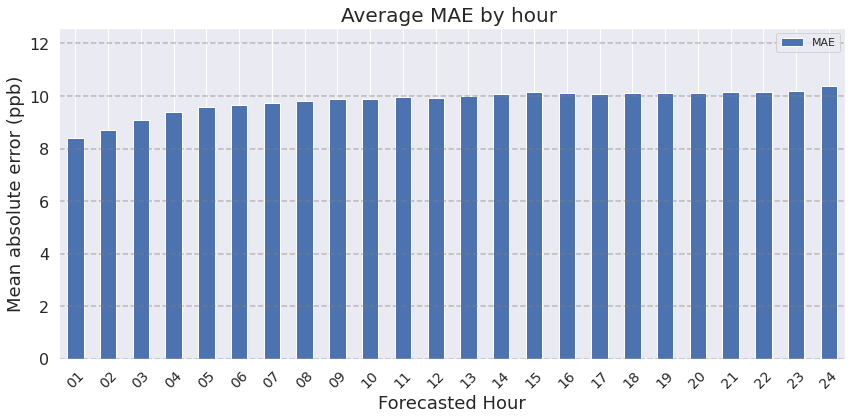

Overall average of RMSE across all hours: 12.9354


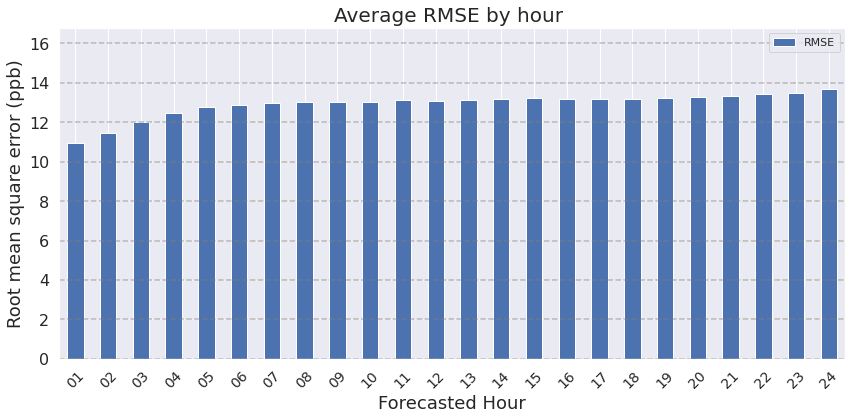

Overall average of R2 across all hours: 0.7293


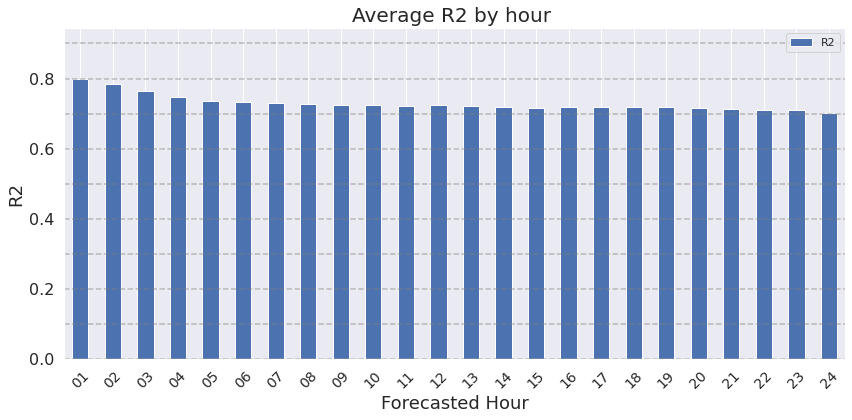

Overall average of Correlation Index across all hours: 0.8796


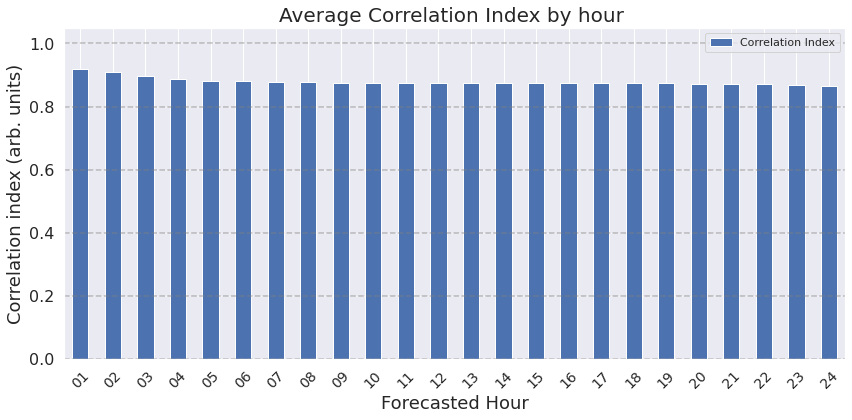

Overall average of Index of agreement across all hours: 0.9102


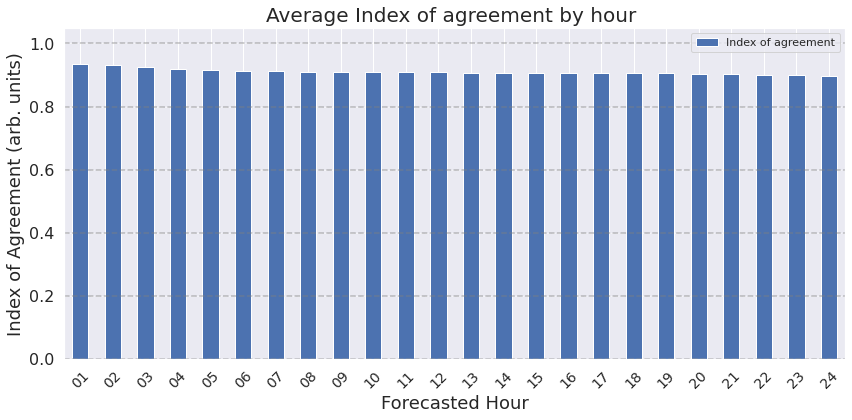

In [37]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt

def average_metric_by_hour(results_df, metric, output_results_folder_img=None, 
                           show_grid=True, x_label='Forecasted Hour', y_label=None, 
                           title_suffix='', save_fig=True, title_str=True, 
                           subtitle=True):
    """
    Generate a bar plot for average metrics by hour.
    
    Parameters:
    ...
    """

    # Helper function to calculate average metrics by hour
    def calculate_average_metrics_by_hour(df, key):
        return df[df['Columna'].str.contains(key)][metric].mean()

    hour_keys = sorted(set(results_df['Columna'].apply(lambda x: x.split('_')[1])), 
                       key=lambda x: int(x.split('plus_')[-1]))
    average_metrics = [calculate_average_metrics_by_hour(results_df, key) for key in hour_keys]
    
    # Create DataFrame
    average_metrics_df = pd.DataFrame({x_label: hour_keys, metric: average_metrics})

    # Overall Average
    overall_average_metric = average_metrics_df[metric].mean()
    print(f"Overall average of {metric} across all hours: {overall_average_metric:.4f}")

    # Plotting
    ax = average_metrics_df.plot(x=x_label, y=metric, kind='bar', figsize=(12, 6))

    # Title Handling
    if isinstance(title_str, str):
        pass
    elif title_str:
        title_str = f'Average {metric} by hour {title_suffix}'
    else:
        title_str = ''
    
    if subtitle:
        title_str += f"\n Overall average of {metric} across all hours: {overall_average_metric:.4f}"
    
    ax.set_title(title_str, fontsize=20)
    ax.set_ylabel(y_label if y_label else metric, fontsize=18)
    ax.set_xlabel(x_label, fontsize=18)
    
    if show_grid:
        y_ticks = plt.gca().get_yticks()
        for y in y_ticks:
            plt.axhline(y, color='gray', linestyle='dashed', alpha=0.5)
        plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    if save_fig and output_results_folder_img:
        plt.savefig(join(output_results_folder_img, f'avg_hours_plot_{metric.lower()}.png'), dpi=300)
    
    plt.show()
# %% Llamada a función para graficar las métricas de resumen de todas las estaciones por hora
average_metric_by_hour(results_df, 'MAE', output_results_folder_img, show_grid=True, x_label='Forecasted Hour', y_label='Mean absolute error (ppb)',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric_by_hour(results_df, 'RMSE', output_results_folder_img, show_grid=True, x_label='Forecasted Hour', y_label='Root mean square error (ppb)',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric_by_hour(results_df, 'R2', output_results_folder_img, show_grid=True, x_label='Forecasted Hour', y_label='R2',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric_by_hour(results_df, 'Correlation Index', output_results_folder_img, show_grid=True, x_label='Forecasted Hour', y_label='Correlation index (arb. units)',title_str=True,title_suffix='', save_fig=True,subtitle=False)
average_metric_by_hour(results_df, 'Index of agreement', output_results_folder_img, show_grid=True, x_label='Forecasted Hour', y_label='Index of Agreement (arb. units)',title_str=True,title_suffix='', save_fig=True,subtitle=False)


24h Errors

plus_01_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 13.039736246992353
Desviación estándar de diferencia en valores máximos diarios: 13.522199017062208


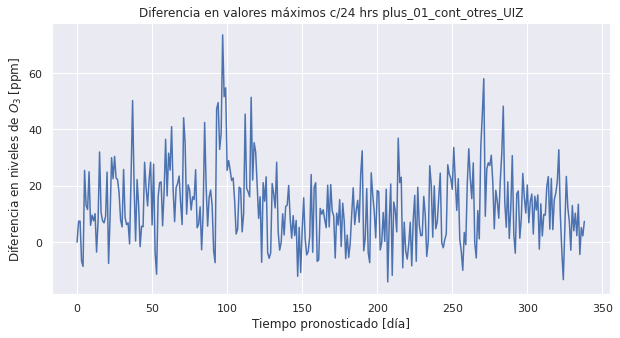

plus_06_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 14.463418893054524
Desviación estándar de diferencia en valores máximos diarios: 17.14187883237976


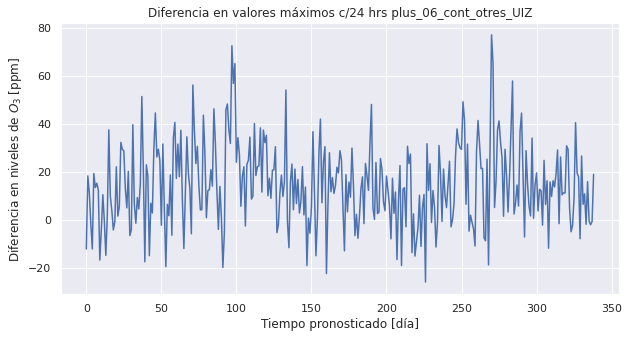

plus_12_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 15.787240801478278
Desviación estándar de diferencia en valores máximos diarios: 17.088781586543682


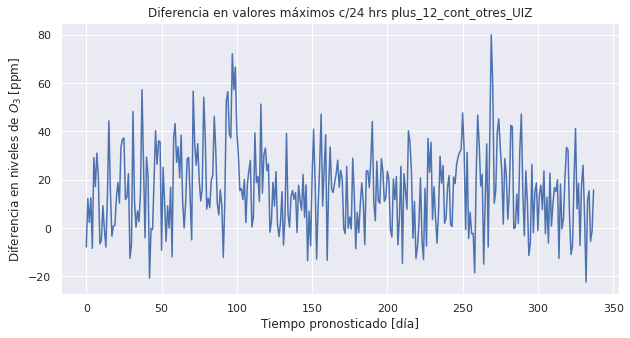

plus_18_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 16.78304729405072
Desviación estándar de diferencia en valores máximos diarios: 16.77103624702238


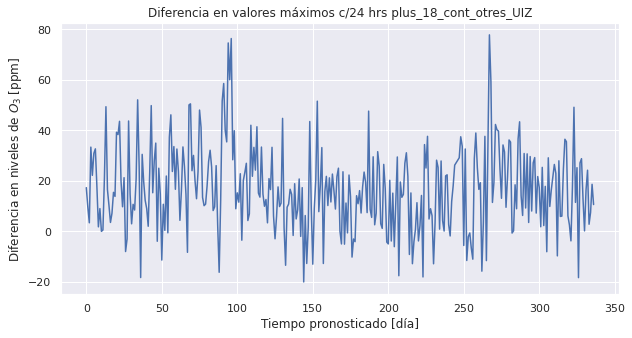

plus_24_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 16.706710702233924
Desviación estándar de diferencia en valores máximos diarios: 19.211152877686324


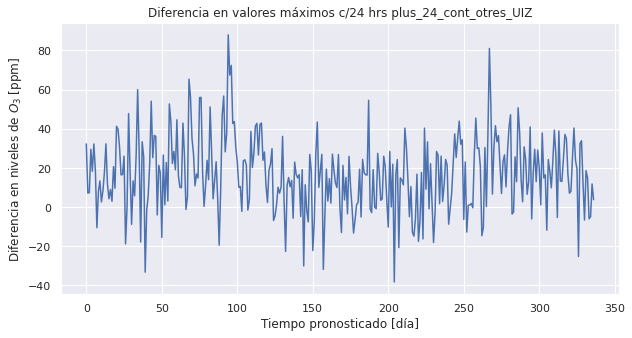

plus_01_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 21.630705791607237
Desviación estándar de diferencia en valores máximos diarios: 16.678764143966887


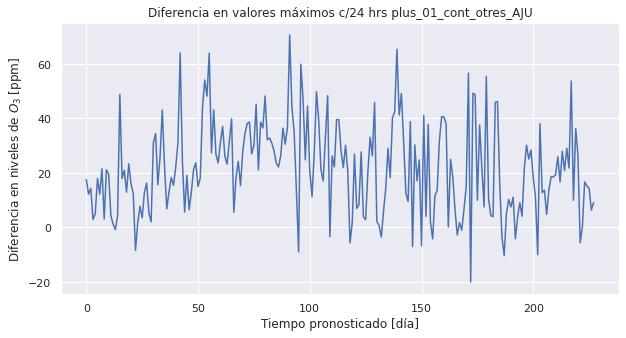

plus_06_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 21.586782322759213
Desviación estándar de diferencia en valores máximos diarios: 18.444291069443576


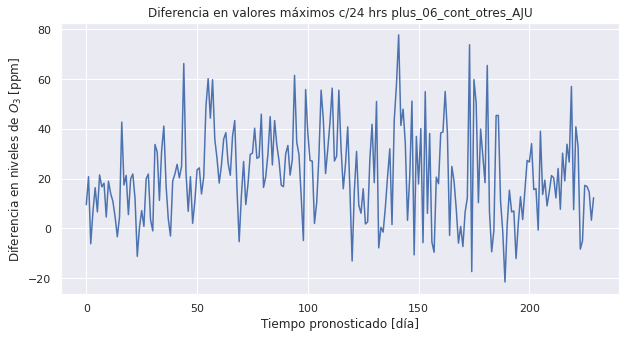

plus_12_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 23.907895262345022
Desviación estándar de diferencia en valores máximos diarios: 17.568925181062806


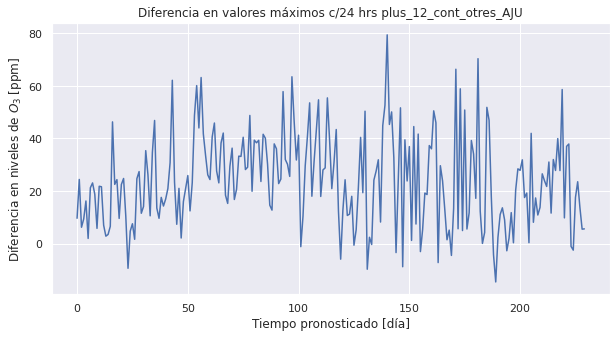

plus_18_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 23.24218126540667
Desviación estándar de diferencia en valores máximos diarios: 17.261004243211875


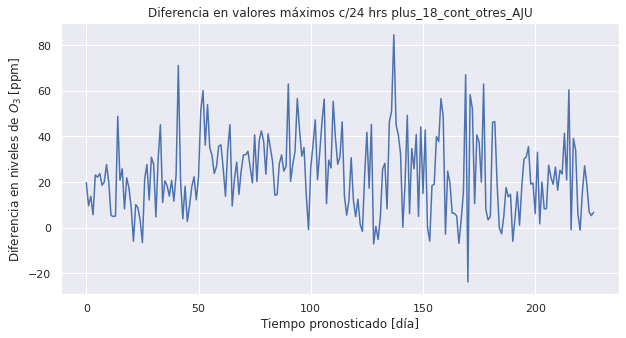

plus_24_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 23.157607650756837
Desviación estándar de diferencia en valores máximos diarios: 18.92266497795229


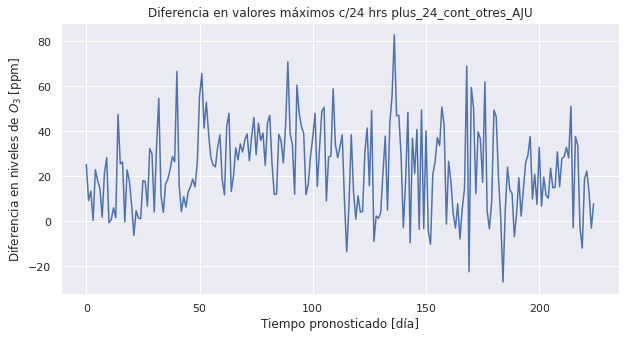

plus_01_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: 4.015920208721626
Desviación estándar de diferencia en valores máximos diarios: 13.613966940471272


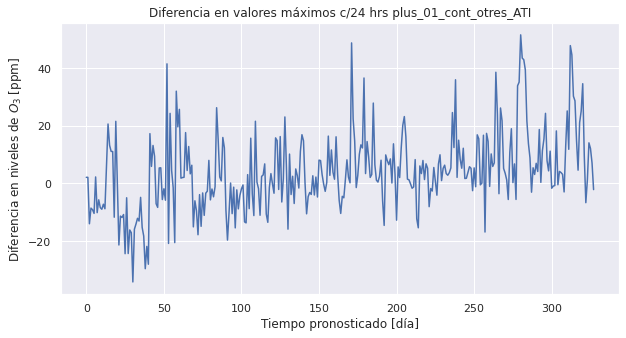

plus_06_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: 5.706118685133914
Desviación estándar de diferencia en valores máximos diarios: 15.816502495283881


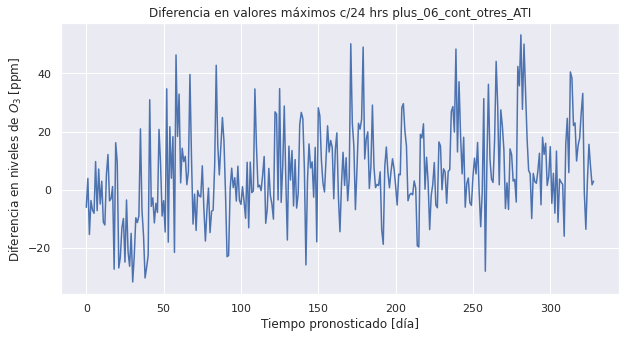

plus_12_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: 6.621999151480672
Desviación estándar de diferencia en valores máximos diarios: 16.184998810314585


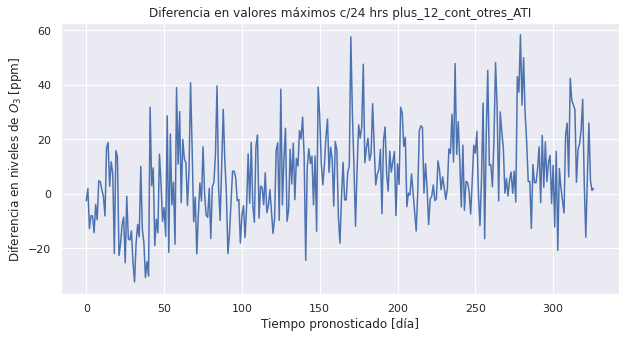

plus_18_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: 3.97133658639517
Desviación estándar de diferencia en valores máximos diarios: 16.43312294535665


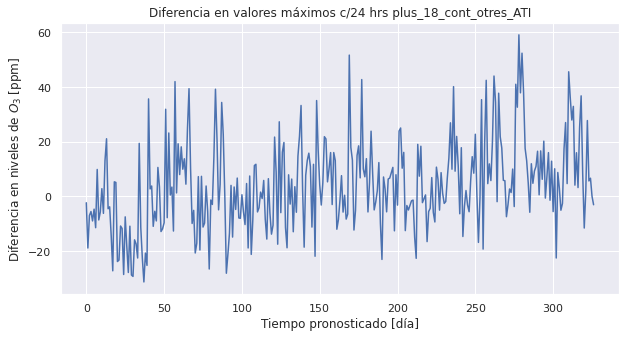

plus_24_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: 6.09067379079463
Desviación estándar de diferencia en valores máximos diarios: 17.481503447238907


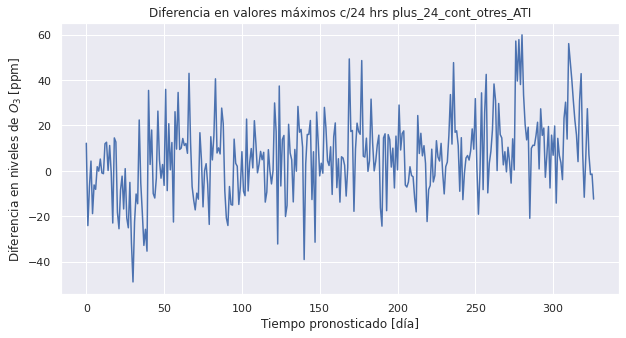

plus_01_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 7.052090516730921
Desviación estándar de diferencia en valores máximos diarios: 13.921887834721351


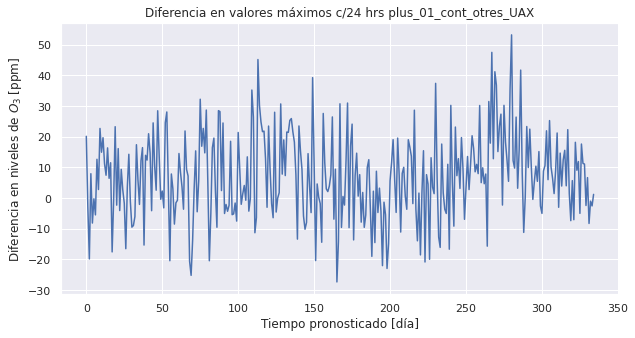

plus_06_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 7.123138402113274
Desviación estándar de diferencia en valores máximos diarios: 17.755622627632967


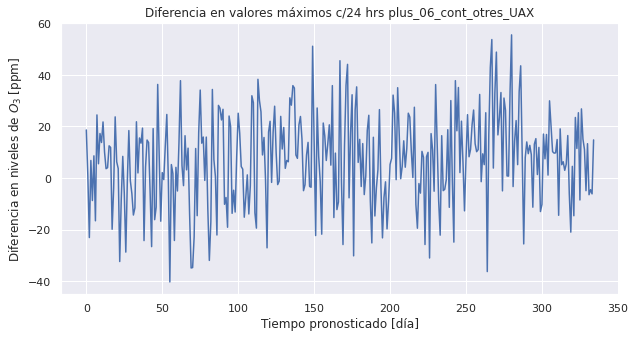

plus_12_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 12.62190754827625
Desviación estándar de diferencia en valores máximos diarios: 16.95117435761311


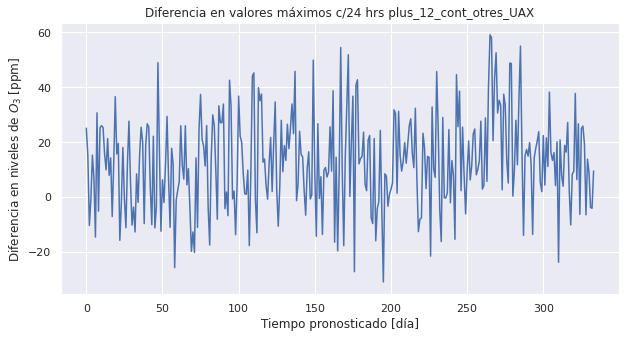

plus_18_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 10.326282524131798
Desviación estándar de diferencia en valores máximos diarios: 17.474566735298062


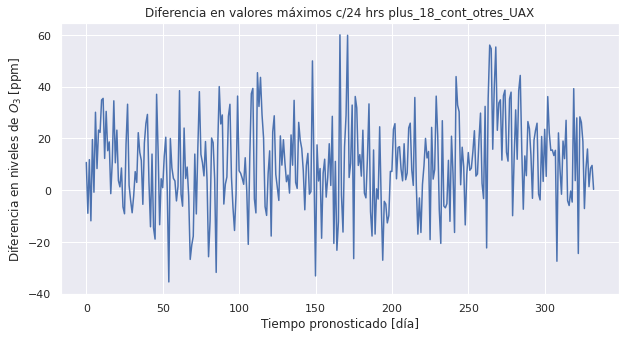

plus_24_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 10.81129072373172
Desviación estándar de diferencia en valores máximos diarios: 19.4101305663419


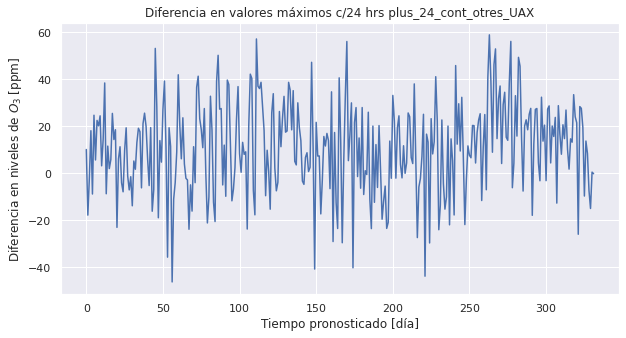

Promedio de h24_max_err_mean: 13.232304218409737
Promedio de h24_max_err_std: 16.882708746830225


In [38]:
# %% Calculo de valores máximos por cada 24 horas. 
# Crear un DataFrame vacío
# TODO, poner opcion para bloquear el graficado.
results_max_df = pd.DataFrame(columns=[
    'max_y_true', 'max_y_pred', 'h24_max_err_mean', 'h24_max_err_std'
])

# Rellenar el DataFrame con los resultados de la función
for cur_column in params_grid:
    print(cur_column)
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std = plot_max_difference(
        cur_column, y_true_df, y_pred_descaled_df)
    results_max_df = results_max_df.append(
        {
            'max_y_true': max_y_true,
            'max_y_pred': max_y_pred,
            'h24_max_err_mean': h24_max_err_mean,
            'h24_max_err_std': h24_max_err_std
        },
        ignore_index=True)

# Calcular el promedio de las cuatro columnas
average_h24_max_err_mean = results_max_df['h24_max_err_mean'].mean()
average_h24_max_err_std = results_max_df['h24_max_err_std'].mean()

print("Promedio de h24_max_err_mean:", average_h24_max_err_mean)
print("Promedio de h24_max_err_std:", average_h24_max_err_std)


In [39]:
# Inicializar nuevas columnas para almacenar los resultados adicionales
results_df['h24_max_err_mean'] = 0.0
results_df['h24_max_err_std'] = 0.0
results_df['h24_mean_err_mean'] = 0.0
results_df['h24_mean_err_std'] = 0.0
errors_dict = {}

# Iterar a través de cada fila en el DataFrame para actualizar las nuevas columnas
for index, row in results_df.iterrows():
    cur_column = row['Columna']
    # Llamar a la función plot_max_and_mean_difference y obtener los resultados
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std, mean_y_true, mean_y_pred, h24_mean_err_mean, h24_mean_err_std = plot_max_and_mean_difference(cur_column, y_true_df, y_pred_descaled_df)
    
    # Actualizar las nuevas columnas con los resultados obtenidos
    results_df.loc[index, 'h24_max_err_mean'] = h24_max_err_mean
    results_df.loc[index, 'h24_max_err_std'] = h24_max_err_std
    results_df.loc[index, 'h24_mean_err_mean'] = h24_mean_err_mean
    results_df.loc[index, 'h24_mean_err_std'] = h24_mean_err_std
    # Almacenar max_y_true, max_y_pred, mean_y_true, y mean_y_pred en el diccionario errors_dict
    errors_dict[cur_column] = {
        'max_y_true': max_y_true,
        'max_y_pred': max_y_pred,
        'mean_y_true': mean_y_true,
        'mean_y_pred': mean_y_pred
    }

plus_01_cont_otres_UIZ
Maximum error mean over 24 hrs: 13.039736246992353
Maximum error std dev over 24 hrs: 13.522199017062208
Mean error mean over 24 hrs: 2.4120225283365806
Mean error std dev over 24 hrs: 5.135551278407476
plus_01_cont_otres_AJU
Maximum error mean over 24 hrs: 21.630705791607237
Maximum error std dev over 24 hrs: 16.678764143966887
Mean error mean over 24 hrs: 2.6224385312600442
Mean error std dev over 24 hrs: 6.36260054316981
plus_01_cont_otres_ATI
Maximum error mean over 24 hrs: 4.015920208721626
Maximum error std dev over 24 hrs: 13.613966940471272
Mean error mean over 24 hrs: -0.03534730299701541
Mean error std dev over 24 hrs: 3.983844324710708
plus_01_cont_otres_CUA
Maximum error mean over 24 hrs: 7.393112576873609
Maximum error std dev over 24 hrs: 14.404663066983312
Mean error mean over 24 hrs: 3.3782275480598045
Mean error std dev over 24 hrs: 6.808613705435604
plus_01_cont_otres_SFE
Maximum error mean over 24 hrs: 15.042021276300604
Maximum error std dev o

plus_04_cont_otres_GAM
Maximum error mean over 24 hrs: 5.927009765711208
Maximum error std dev over 24 hrs: 15.46515453229544
Mean error mean over 24 hrs: -2.804476908371274
Mean error std dev over 24 hrs: 4.714074796288037
plus_04_cont_otres_IZT
Maximum error mean over 24 hrs: 5.588732187696498
Maximum error std dev over 24 hrs: 17.058925414390764
Mean error mean over 24 hrs: 0.1836124132577177
Mean error std dev over 24 hrs: 4.733339666206166
plus_04_cont_otres_CCA
Maximum error mean over 24 hrs: 12.452880429026145
Maximum error std dev over 24 hrs: 18.337493106842164
Mean error mean over 24 hrs: 2.4158836929689653
Mean error std dev over 24 hrs: 6.2255454572106785
plus_04_cont_otres_HGM
Maximum error mean over 24 hrs: 4.327807055579291
Maximum error std dev over 24 hrs: 13.472857651913742
Mean error mean over 24 hrs: 0.652277006043328
Mean error std dev over 24 hrs: 2.084131171250784
plus_04_cont_otres_LPR
Maximum error mean over 24 hrs: 0.7542405966722999
Maximum error std dev over

plus_07_cont_otres_NEZ
Maximum error mean over 24 hrs: 14.697513110395791
Maximum error std dev over 24 hrs: 16.219828610346624
Mean error mean over 24 hrs: 3.2585726448879146
Mean error std dev over 24 hrs: 5.2069081465090505
plus_07_cont_otres_INN
Maximum error mean over 24 hrs: -5.319551298101861
Maximum error std dev over 24 hrs: 14.951581154113336
Mean error mean over 24 hrs: -9.53328011698586
Mean error std dev over 24 hrs: 6.063377470712287
plus_07_cont_otres_AJM
Maximum error mean over 24 hrs: 14.410226451540456
Maximum error std dev over 24 hrs: 20.469838159337648
Mean error mean over 24 hrs: 1.2310341060354486
Mean error std dev over 24 hrs: 7.6301257920262895
plus_07_cont_otres_VIF
Maximum error mean over 24 hrs: 14.376326484363165
Maximum error std dev over 24 hrs: 14.790861269614593
Mean error mean over 24 hrs: 1.5516796327804043
Mean error std dev over 24 hrs: 5.166290475231735
plus_08_cont_otres_UIZ
Maximum error mean over 24 hrs: 15.978431434406291
Maximum error std dev

Maximum error std dev over 24 hrs: 17.730836403587737
Mean error mean over 24 hrs: -0.2746384377657434
Mean error std dev over 24 hrs: 5.68916862047633
plus_11_cont_otres_CCA
Maximum error mean over 24 hrs: 14.481757793585903
Maximum error std dev over 24 hrs: 18.90529285738197
Mean error mean over 24 hrs: 1.8138604498396564
Mean error std dev over 24 hrs: 7.132428774193497
plus_11_cont_otres_HGM
Maximum error mean over 24 hrs: 8.196980667114257
Maximum error std dev over 24 hrs: 10.26671138904398
Mean error mean over 24 hrs: 0.24156337976455688
Mean error std dev over 24 hrs: 1.7546928235902222
plus_11_cont_otres_LPR
Maximum error mean over 24 hrs: 2.6949406653898835
Maximum error std dev over 24 hrs: 15.323990125507809
Mean error mean over 24 hrs: -2.953979486096099
Mean error std dev over 24 hrs: 5.228568366716563
plus_11_cont_otres_MGH
Maximum error mean over 24 hrs: 8.524602953770035
Maximum error std dev over 24 hrs: 18.76110968931897
Mean error mean over 24 hrs: -1.1894064611489

plus_14_cont_otres_AJM
Maximum error mean over 24 hrs: 18.210910391692376
Maximum error std dev over 24 hrs: 17.471704076710562
Mean error mean over 24 hrs: 0.6147597891888948
Mean error std dev over 24 hrs: 7.3605520863530876
plus_14_cont_otres_VIF
Maximum error mean over 24 hrs: 16.2446580576831
Maximum error std dev over 24 hrs: 14.81476815216504
Mean error mean over 24 hrs: 1.0233507154182735
Mean error std dev over 24 hrs: 5.2869437408930136
plus_15_cont_otres_UIZ
Maximum error mean over 24 hrs: 17.121722362450594
Maximum error std dev over 24 hrs: 16.791337189799155
Mean error mean over 24 hrs: 3.270929767535283
Mean error std dev over 24 hrs: 5.617539614883972
plus_15_cont_otres_AJU
Maximum error mean over 24 hrs: 25.005365618344012
Maximum error std dev over 24 hrs: 16.799732249393756
Mean error mean over 24 hrs: 2.46204807515117
Mean error std dev over 24 hrs: 6.54156936762904
plus_15_cont_otres_ATI
Maximum error mean over 24 hrs: 5.607966213691525
Maximum error std dev over 2

plus_18_cont_otres_HGM
Maximum error mean over 24 hrs: 8.959658728705513
Maximum error std dev over 24 hrs: 9.525800969876187
Mean error mean over 24 hrs: 0.38219992319742846
Mean error std dev over 24 hrs: 1.5853581812793927
plus_18_cont_otres_LPR
Maximum error mean over 24 hrs: 3.9216938900809755
Maximum error std dev over 24 hrs: 16.592986236110548
Mean error mean over 24 hrs: -2.7923162571497273
Mean error std dev over 24 hrs: 5.257347236485915
plus_18_cont_otres_MGH
Maximum error mean over 24 hrs: 7.508287732647654
Maximum error std dev over 24 hrs: 19.34243527644751
Mean error mean over 24 hrs: -1.574330008682988
Mean error std dev over 24 hrs: 5.373692004515992
plus_18_cont_otres_CAM
Maximum error mean over 24 hrs: 1.994302939062249
Maximum error std dev over 24 hrs: 23.320739388739256
Mean error mean over 24 hrs: -0.19445407254510821
Mean error std dev over 24 hrs: 6.6080241640870545
plus_18_cont_otres_FAC
Maximum error mean over 24 hrs: -0.07027392304701612
Maximum error std d

plus_21_cont_otres_PED
Maximum error mean over 24 hrs: 4.430261099086427
Maximum error std dev over 24 hrs: 18.627984017793757
Mean error mean over 24 hrs: 0.6022351926787263
Mean error std dev over 24 hrs: 6.1104293566287815
plus_21_cont_otres_TAH
Maximum error mean over 24 hrs: 13.855409280820327
Maximum error std dev over 24 hrs: 16.78653481257569
Mean error mean over 24 hrs: 0.7736453434283086
Mean error std dev over 24 hrs: 5.251427244245225
plus_21_cont_otres_GAM
Maximum error mean over 24 hrs: 7.694218048268119
Maximum error std dev over 24 hrs: 16.19413920849832
Mean error mean over 24 hrs: -3.4946088309341903
Mean error std dev over 24 hrs: 5.095965741573029
plus_21_cont_otres_IZT
Maximum error mean over 24 hrs: 8.56128867180339
Maximum error std dev over 24 hrs: 19.022643749611344
Mean error mean over 24 hrs: -0.16161647399553472
Mean error std dev over 24 hrs: 5.962582401170127
plus_21_cont_otres_CCA
Maximum error mean over 24 hrs: 11.56023719045851
Maximum error std dev ove

Mean error std dev over 24 hrs: 6.282945963342231
plus_23_cont_otres_AJM
Maximum error mean over 24 hrs: 16.48049669680388
Maximum error std dev over 24 hrs: 20.614635135368342
Mean error mean over 24 hrs: 0.5789689737433587
Mean error std dev over 24 hrs: 8.144596915875706
plus_23_cont_otres_VIF
Maximum error mean over 24 hrs: 15.229831471627588
Maximum error std dev over 24 hrs: 16.651122916592342
Mean error mean over 24 hrs: 2.079459472640004
Mean error std dev over 24 hrs: 5.638388183308749
plus_24_cont_otres_UIZ
Maximum error mean over 24 hrs: 16.706710702233924
Maximum error std dev over 24 hrs: 19.211152877686324
Mean error mean over 24 hrs: 2.8590792107417013
Mean error std dev over 24 hrs: 6.822255850820102
plus_24_cont_otres_AJU
Maximum error mean over 24 hrs: 23.157607650756837
Maximum error std dev over 24 hrs: 18.92266497795229
Mean error mean over 24 hrs: 2.327860103183323
Mean error std dev over 24 hrs: 7.250065810688377
plus_24_cont_otres_ATI
Maximum error mean over 24 

## <a id="Scatter_Plots_of_24h_Error_Graphics">Scatter Plots of 24h Error Eval</a>
### Max, Average
- [Return to Plots Index](#Plots_index)  

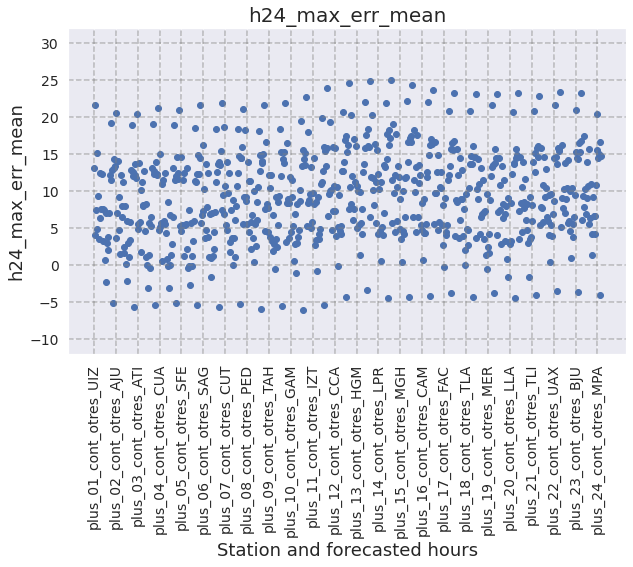

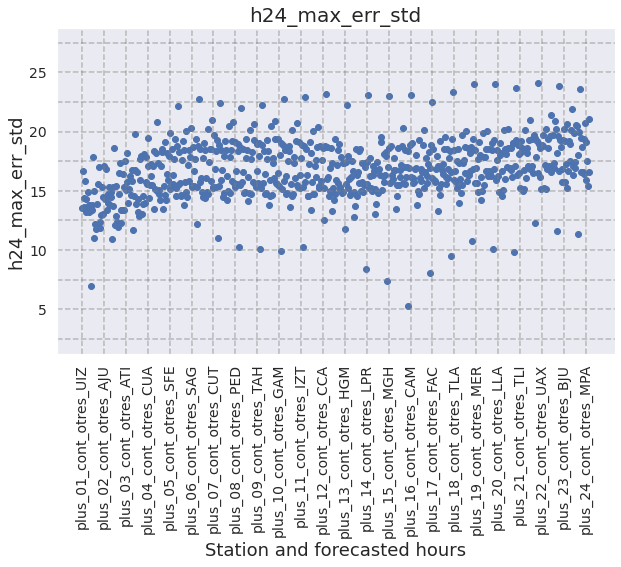

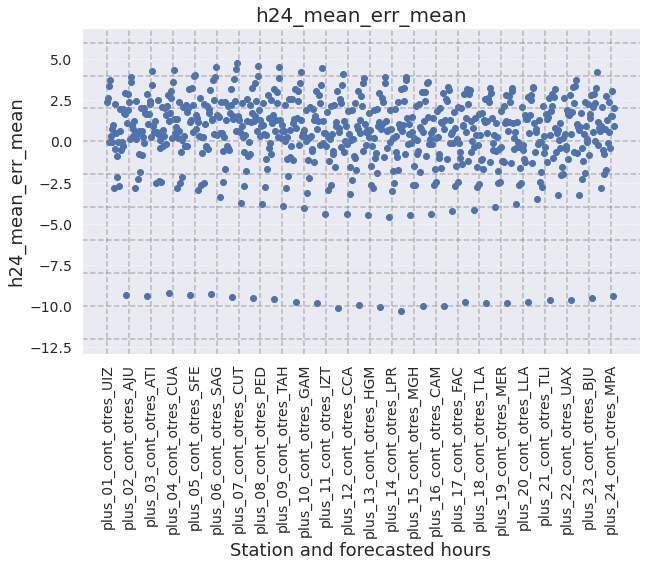

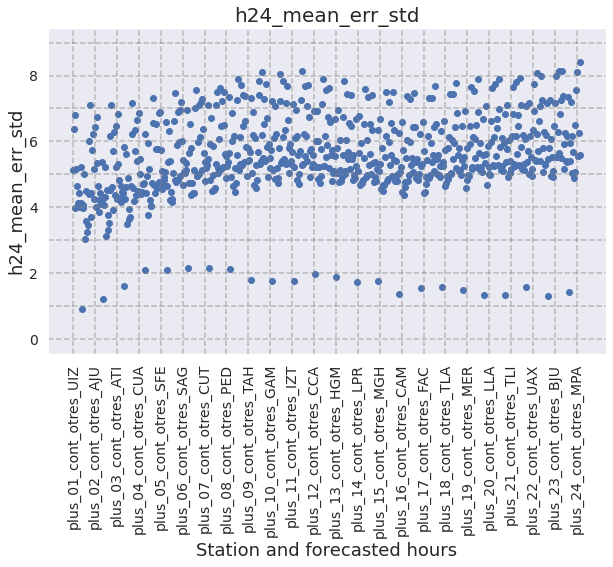

In [40]:
scatter_plot_by_column(results_df, 'h24_max_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_max_err_std',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_std',
                output_results_folder_img)

## <a id="Bar_Charts_of_24h_Errors_over_Stations">Bar Charts of 24h Errors over Stations</a>
### Max, Average
- [Return to Plots Index](#Plots_index)  

Per station h24_max_err_mean: 9.2702


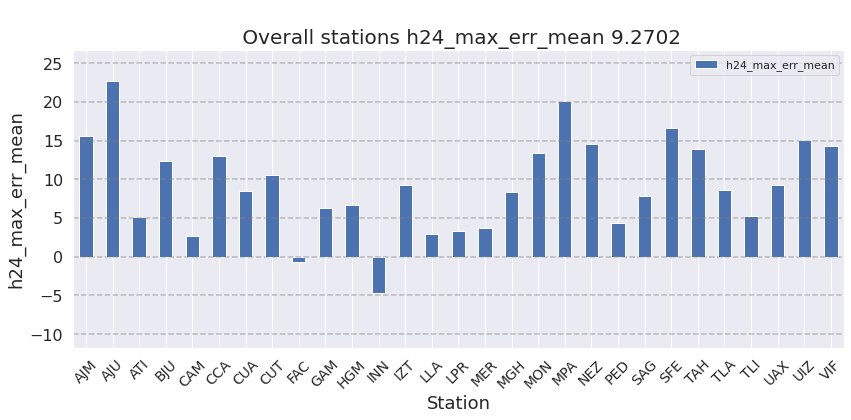

Per station h24_max_err_std: 16.7344


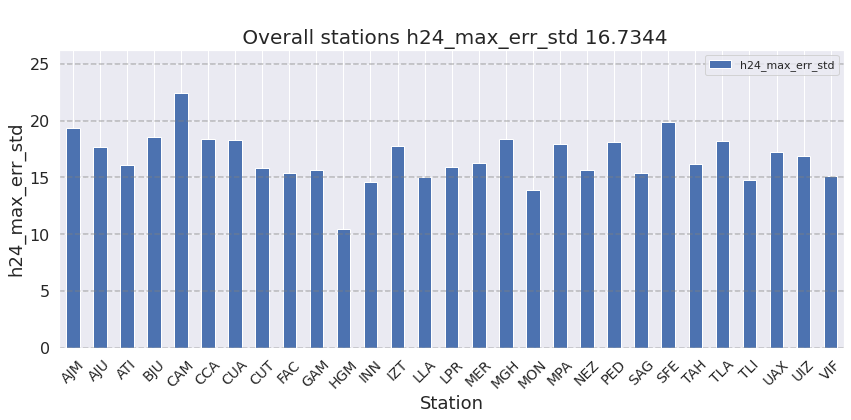

Per station h24_mean_err_mean: 0.3047


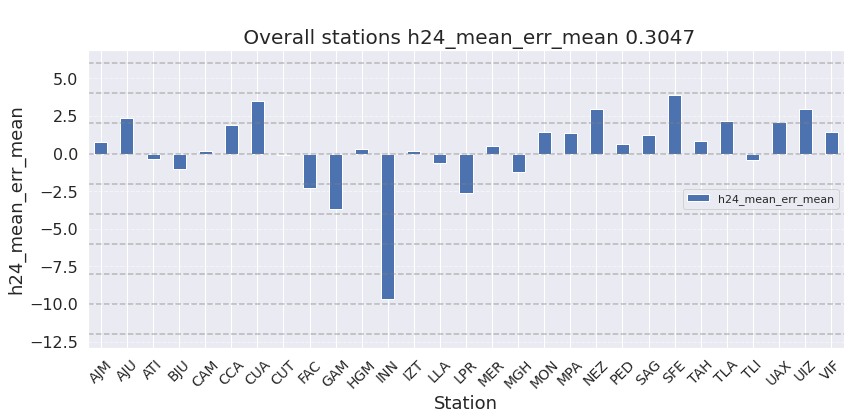

Per station h24_mean_err_std: 5.5548


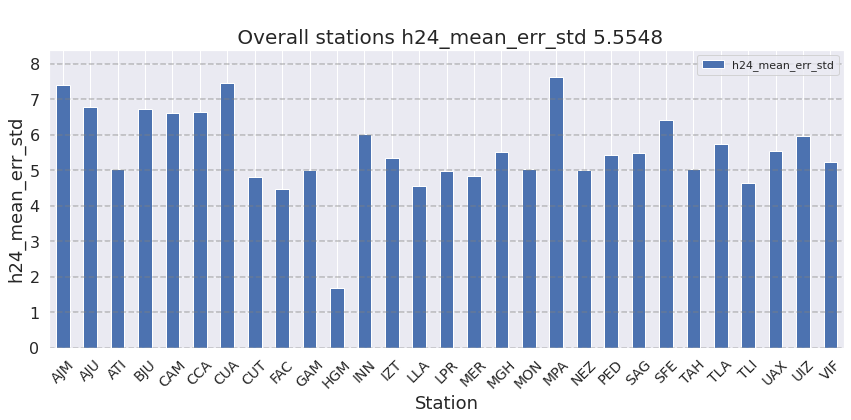

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Tu código aquí callando warnings
    average_metric(results_df, 'h24_max_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_max_err_std', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_std', output_results_folder_img)

## <a id="Results_df_Table">Results_df Table</a>
- [Return to Plots Index](#Plots_index)  

In [42]:
results_df

Columna  Correlation Index        MAE          MAPE  \
0    plus_01_cont_otres_UIZ           0.939165   8.709189  1.821618e+14   
1    plus_01_cont_otres_AJU           0.910427  11.992657  2.698329e+13   
2    plus_01_cont_otres_ATI           0.922638   6.993101  4.606342e-01   
3    plus_01_cont_otres_CUA           0.887523   9.320794  1.734617e+14   
4    plus_01_cont_otres_SFE           0.923270   9.452324  4.477150e-01   
..                      ...                ...        ...           ...   
691  plus_24_cont_otres_MON           0.880904  10.972673  5.788248e+12   
692  plus_24_cont_otres_NEZ           0.885270  10.556931  2.729143e+13   
693  plus_24_cont_otres_INN           0.731702  12.782560  7.250953e-01   
694  plus_24_cont_otres_AJM           0.835438  11.954727  4.713851e-01   
695  plus_24_cont_otres_VIF           0.871343  10.208917  6.454470e+13   

            MSE       RMSE        R2  Index of agreement     Hora Estación  \
0    137.412276  11.722298  0.834595            0.944245  plus_01      UIZ   
1    236.971964  15.393894  0.682600            0.862956  plus_01      AJU   
2     88.641404   9.414956  0.850502            0.956915  plus_01      ATI   
3    151.604356  12.312772  0.759845            0.924540  plus_01      CUA   
4    157.136490  12.535409  0.810109            0.938235  plus_01      SFE   
..          ...        ...       ...                 ...      ...      ...   
691  189.496964  13.765790  0.723833            0.895324  plus_24      MON   
692  196.799374  14.028520  0.741350            0.909305  plus_24      NEZ   
693  218.392108  14.778096  0.006794            0.715835  plus_24      INN   
694  245.750755  15.676439  0.665083            0.869975  plus_24      AJM   
695  183.131680  13.532615  0.705548            0.887167  plus_24      VIF   

     h24_max_err_mean  h24_max_err_std  h24_mean_err_mean  h24_mean_err_std  
0           13.039736        13.522199           2.412023          5.135551  
1           21.630706        16.678764           2.622439          6.362601  
2            4.015920        13.613967          -0.035347          3.983844  
3            7.393113        14.404663           3.378228          6.808614  
4           15.042021        15.828224           3.707916          5.174393  
..                ...              ...                ...               ...  
691         14.386832        15.933724           1.554167          5.556815  
692         14.918104        17.530749           3.076061          5.554145  
693         -4.019052        15.411520          -9.383598          6.256420  
694         16.539667        21.025248           0.922173          8.398947  
695         14.690049        16.629024           2.030937          5.582173  

[696 rows x 14 columns]

In [43]:
# saving results_df table into a csv file
results_df.to_csv(join(output_results_folder_data, 'results_df.csv'),
                  index=False)

## <a id="Histogram_Fit">Histogram Fit</a>
- [Return to Plots Index](#Plots_index)  

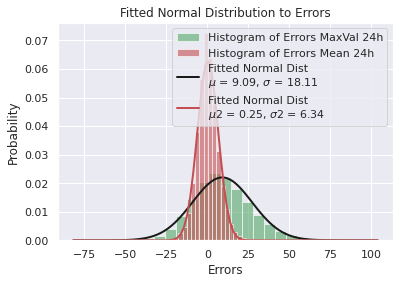

In [44]:
# Case for overall h24_max_err of the model

overall_errors = []

# Loop over the dictionary keys and values
for columna, values in errors_dict.items():
    max_y_true = values['max_y_true']
    max_y_pred = values['max_y_pred']
    errors = max_y_true - max_y_pred

    # Filtering out zeros
    for error in errors:
        if error != 0:
            overall_errors.append(error)


# Convert to numpy array for easier statistical analysis
overall_errors = np.array(overall_errors)

# Fit a normal distribution to the errors data
mu, std = norm.fit(overall_errors)

# Create a histogram of the errors
plt.hist(overall_errors, bins=25, density=True, alpha=0.6, color='g', label="Histogram of Errors MaxVal 24h")

# Create a PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
overall_errors2 = []

# Loop over the dictionary keys and values
for columna, values in errors_dict.items():
    max_y_true = values['mean_y_true']
    max_y_pred = values['mean_y_pred']
    errors = max_y_true - max_y_pred

    # Filtering out zeros

    for error in errors:
        if error != 0:
            overall_errors2.append(error)


# Convert to numpy array for easier statistical analysis

overall_errors2 = np.array(overall_errors2)
plt.hist(overall_errors2, bins=25, density=True, alpha=0.6, color='r', label="Histogram of Errors Mean 24h")

mu2, std2 = norm.fit(overall_errors2)
p2 = norm.pdf(x, mu2, std2)


plt.plot(x, p, 'k', linewidth=2, label=f"Fitted Normal Dist\n$\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}")
plt.plot(x, p2, 'r', linewidth=2, label=f"Fitted Normal Dist\n$\mu2$ = {mu2:.2f}, $\sigma2$ = {std2:.2f}")

plt.xlabel("Errors")
plt.ylabel("Probability")
plt.title("Fitted Normal Distribution to Errors")
plt.legend()
plt.show()

#mean_np, std_np, mu, std

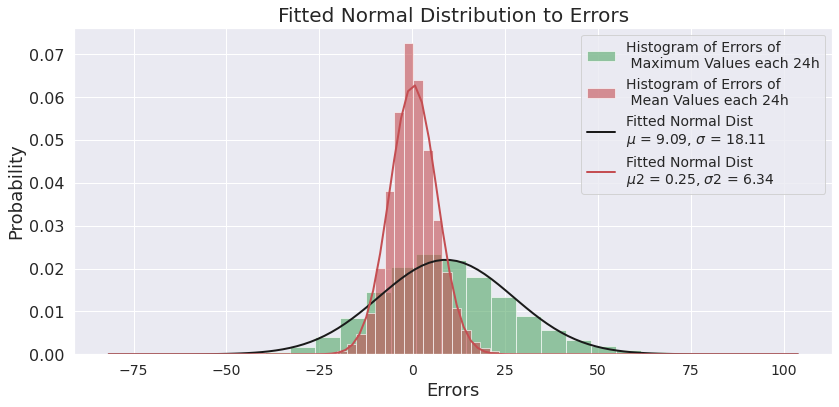

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


overall_errors = []

# Loop over the dictionary keys and values
for columna, values in errors_dict.items():
    max_y_true = values['max_y_true']
    max_y_pred = values['max_y_pred']
    errors = max_y_true - max_y_pred

    # Filtering out zeros
    for error in errors:
        if error != 0:
            overall_errors.append(error)

# Convert to numpy array for easier statistical analysis
overall_errors = np.array(overall_errors)

# Fit a normal distribution to the errors data
mu, std = norm.fit(overall_errors)

# Adjusting the size of the plot and font sizes for publication
plt.figure(figsize=(12, 6))  
plt.rcParams.update({'font.size': 18}) 

# Create a histogram of the errors
plt.hist(overall_errors, bins=25, density=True, alpha=0.6, color='g', label="Histogram of Errors of\n Maximum Values each 24h")

# Create a PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

overall_errors2 = []

# Loop over the dictionary keys and values
for columna, values in errors_dict.items():
    max_y_true = values['mean_y_true']
    max_y_pred = values['mean_y_pred']
    errors = max_y_true - max_y_pred

    # Filtering out zeros
    for error in errors:
        if error != 0:
            overall_errors2.append(error)

# Convert to numpy array for easier statistical analysis
overall_errors2 = np.array(overall_errors2)

plt.hist(overall_errors2, bins=25, density=True, alpha=0.6, color='r', label="Histogram of Errors of\n Mean Values each 24h")

mu2, std2 = norm.fit(overall_errors2)
p2 = norm.pdf(x, mu2, std2)

plt.plot(x, p, 'k', linewidth=2, label=f"Fitted Normal Dist\n$\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}")
plt.plot(x, p2, 'r', linewidth=2, label=f"Fitted Normal Dist\n$\mu2$ = {mu2:.2f}, $\sigma2$ = {std2:.2f}")
plt.xlabel("Errors", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.title("Fitted Normal Distribution to Errors", fontsize=20)


#plt.plot(x, p, 'k', linewidth=2, label=f"Fitted Normal Dist\n$\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}")
#plt.plot(x, p2, 'r', linewidth=2, label=f"Fitted Normal Dist\n$\mu2$ = {mu2:.2f}, $\sigma2$ = {std2:.2f}")

#plt.xlabel("Errors", fontsize=18)
#plt.ylabel("Probability", fontsize=18)
#plt.title("Fitted Normal Distribution to Errors", fontsize=20)

plt.legend(fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=16)

plt.tight_layout()

# Uncomment the following line to save the figure
# plt.savefig('path_to_save_figure.png', dpi=300)

plt.show()


## <a id="Overall_Results_Table">Overall Results Table</a>
- [Return to Plots Index](#Plots_index)  

In [46]:
# Overall values of results for the model
overall = results_df.mean()
print(overall)


Correlation Index     8.796458e-01
MAE                   9.821970e+00
MAPE                  1.515398e+14
MSE                   1.702067e+02
RMSE                  1.293540e+01
R2                    7.293114e-01
Index of agreement    9.102280e-01
h24_max_err_mean      9.270167e+00
h24_max_err_std       1.673440e+01
h24_mean_err_mean     3.046950e-01
h24_mean_err_std      5.554813e+00
dtype: float64
